# Stack Traces Project

## Importing the necessary libraries

In [29]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from typing import Tuple, List, Optional, Union, Tuple
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import string
import seaborn as sns
import datetime
from itertools import permutations
import heapq
import csv

# pd.options.display.max_colwidth = 500
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Setting up the project environment

In [30]:
# .csv configuration
encoding = "utf-8"
delimiter = None
working_directory_path = "./"

## Loading the question dataset

In [31]:
pure_data = working_directory_path + "question_tag.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [32]:
df.shape

(163194, 11)

## Answering the first research question (RQ1)

### Filtering the specific tags

In [41]:
def tag_filter(pref_tags: List, tags: str) -> bool:
    regex = ""
    for tag in pref_tags:
        regex += '(?=.*\\b'+ tag +'([+-]?([0-9]*[.])?[0-9]*)\\b)'
    regex = r"^" + regex + ".*$"
    tags = tags.strip().lower()
    match_result = re.match(regex, tags, re.MULTILINE | re.IGNORECASE)
    if match_result is None:
        return 0
    else:
        return 1

In [42]:
tags = ["pytorch", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))

In [43]:
df_w_PT_tags = df[df['HasPreferableTags']==True]

In [44]:
df_w_PT_tags = df_w_PT_tags.drop(['HasPreferableTags'], axis='columns')

In [45]:
df_w_PT_tags.shape

(6163, 11)

### Extracting the code parts from body

In [47]:
index = 0
def extract_code_blocks(body: str) -> List:
    global index
    
    if index in [107, 448, 2680, 2715, 3247, 5665]:  # <~~~ ignore this data
        index += 1
        return []  
    regex = r"<pre((.*?)|(\n)*)*><code>((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>)"
    # regex = r"<pre><code>((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>)"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result=[]
    
    try:
        for matchNum, match in enumerate(matches):
            code = match.group()
            code = code.replace("<pre><code>", "")
            code = code.replace("</pre></code>", "")
            code = code.replace("</code></pre>", "")
            result.append(code)
    except:
        print("\n Error(1): ")
        print(body)
        return None
    
    index += 1

    return result

In [48]:
df_w_PT_tags['Code'] = df_w_PT_tags['Body'].apply(lambda row_body: extract_code_blocks(row_body))

For testing:

In [49]:
# print(df_w_tags.iloc[7]['Body'])
# print(type(extract_code_blocks(df_w_tags.iloc[7]['Body'])))
# print(len(extract_code_blocks(df_w_tags.iloc[7]['Body'])))
# print(extract_code_blocks(df_w_tags.iloc[7]['Body'])[0])

Reset the index of dataframe:

In [50]:
df_w_PT_tags = df_w_PT_tags.reset_index(drop=True)

#### Finding the number of questions that have a code or not

In [51]:
coun_w_c = 0
coun_wo_c = 0

def counting_w_or_wo_code(row_code: List) -> bool:
    global coun_w_c
    global coun_wo_c
    
    if row_code:
        coun_w_c = coun_w_c + 1
        return True
    else:
        coun_wo_c = coun_wo_c + 1
        return False

In [52]:
df_w_PT_tags['Has_code'] = df_w_PT_tags['Code'].apply(lambda row_code: counting_w_or_wo_code(row_code))

### Extracting the text parts from body

In [53]:
def extract_text_blocks(i: int, body: str) -> Optional[List]:
    # It's bug
    if i in [10005, 14212, 21959, 26677, 53279]: 
        body = body + "</p>"

    regex = r"<p>((.*?)|(\n)*)*<\/p>"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result=[]

    try:
        for matchNum, match in enumerate(matches, start=1):
            text = match.group()
            text = text.replace("<p>", "")
            text = text.replace("</p>", "")
            result.append(text)
    except:
        print("\n Error(1): ")
        print(text)
        return None

    return result

In [54]:
df_w_PT_tags['Text'] = df_w_PT_tags.apply(lambda row: extract_text_blocks(row.name, row.Body), axis=1)

#### Finding the number of body words

In [55]:
def find_q_text_words(text_list: List) -> int:
    word_count = 0
    for text in text_list:
        word_count += sum([i.strip(string.punctuation).isalpha() for i in text.split()])
    return word_count

In [56]:
df_w_PT_tags['Q_text_words_num'] = df_w_PT_tags["Text"].apply(lambda text_list: find_q_text_words(text_list))

Save the dataframe as csv format

In [57]:
# df_w_Tens_tags.to_csv('./amin_result_v1.csv', encoding='utf-8')

### Find the Regular Expressions for Unix and Windows base Pathnames

#### 1) Absolute and Relative Pathnames in UNIX OS

Stack/trace example: https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed

Find the restrictions and limitations related to the Unix pathnames: https://www.cyberciti.biz/faq/linuxunix-rules-for-naming-file-and-directory-names/

Online regular expression environment for testing: https://regex101.com/r/ZyEx5u/4

> Regular Expression: "[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)"

#### 1) Pathnames in Windows OS

Stack/trace example: https://stackoverflow.com/questions/49434031/tensorflow-on-windows-cpu-version-importerror-no-module-named-pywrap-tensorf

Find the restrictions and limitations related to the Windows pathnames: <br /> 
https://docs.microsoft.com/en-us/dotnet/standard/io/file-path-formats <br />
https://docs.microsoft.com/en-us/windows/win32/fileio/naming-a-file

Online regular expression environment for testing: https://regex101.com/r/L6xmCa/1 , https://regex101.com/r/wz1WqW/1

> Regular Expression: "[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)"

In [58]:
def extract_pathnames_from_code_column(code_sec: List) -> Tuple[str, List]: 
    try:
        result_post_file_names = []
        OS_flag = None
        
        for code in code_sec:
            regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
            regex_windows = r"(([a-zA-Z]:)|\~)\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
            pattern_unix  = re.compile(regex_unix)
            pattern_windows  = re.compile(regex_windows)
            if pattern_unix.search(code):
                OS_flag = "unix"
                break
            elif pattern_windows.search(code):
                OS_flag = "windows"
                break
        
        if OS_flag == "unix":
            for code in code_sec:
                regex = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
                code = code.replace("\\n", "\n")
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                matches = re.finditer(regex, code, re.MULTILINE)
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[1].strip(), match.groups()[4].strip()))
#                     file_names_for_each_code_part.append(match.groups()[1].strip())
                    # print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
                    # for groupNum in range(0, len(match.groups())):
                        # groupNum = groupNum + 1
                        # print ("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))
#                 print(file_names_for_each_code_part)
#                 file_names_for_each_code_part = list(set(file_names_for_each_code_part))            # Create a unique list
#                 print(file_names_for_each_code_part)
                
                if file_names_for_each_code_part:                                                   # Ignore the empty list
                    result_post_file_names.append(file_names_for_each_code_part)
                    
        elif OS_flag == "windows":
            for code in code_sec:
                regex = r"(([a-zA-Z]:)|\~)\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                matches = re.finditer(regex, code, re.MULTILINE)                            
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[3].strip(), match.groups()[6].strip()))
#                     file_names_for_each_code_part.append(match.groups()[1].strip())
                    # print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
                    # for groupNum in range(0, len(match.groups())):
                        # groupNum = groupNum + 1
                        # print ("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))
#                 file_names_for_each_code_part = [s.strip() for s in file_names_for_each_code_part]  # Strip the list
#                 file_names_for_each_code_part = list(set(file_names_for_each_code_part))            # create a unique list
                if file_names_for_each_code_part:                                                   # Ignore the empty list
                    result_post_file_names.append(file_names_for_each_code_part)
            
    except:
        print("\n Error(2): \n", code_sec)
        return None, None

    return OS_flag, result_post_file_names

In [59]:
# Example for Unix path
# https://stackoverflow.com/questions/51839415/tensorflow-valueerror-rank-mismatch
# df_w_Tens_tags.iloc[9][:]
extract_pathnames_from_code_column(df_w_PT_tags["Code"][3])

('unix',
 [[('dataloader', '__next__'),
   ('sampler', '__iter__'),
   ('sampler', '__iter__')]])

In [23]:
# Example for Windows path
# df_w_Tens_tags['Code'] = df_w_Tens_tags['Body'].apply(lambda row_body: extract_code_blocks(row_body))
# print(df_w_Tens_tags["Code"][9])
# extract_pathnames_from_code_column(df_w_Tens_tags["Code"][84])
# extract_pathnames_from_code_column(df_w_Tens_tags["Code"][606])

In [24]:
# df_w_Tens_tags["Body"][606]

In [60]:
df_w_PT_tags['Bugy_py_files'] = df_w_PT_tags['Code'].apply(lambda row_code_ex: extract_pathnames_from_code_column(row_code_ex))

Save the dataframe as csv format

In [61]:
df_w_PT_tags.loc[df_w_PT_tags['Id'] == 46509039]

,Id,PostTypeId,AcceptedAnswerId,CreationDate,ViewCount,AnswerCount,CommentCount,Score,Title,Body,Tags,Code,Has_code,Text,Q_text_words_num,Bugy_py_files
22,46509039,1,NaN,2017-10-01 03:50:18,4559,3,2,3,Pytorch: define custom function,"<p>I wanted to write my own activation function, but I got a problem. Saying the matrix multiplication will call <code>.data</code>. I searched but got little useful information. Any help will be appreciated. The error information is </p>\n\n<pre class=""lang-none prettyprint-override""><code> Traceback (most recent call last):\n File ""defineAutogradFuncion.py"", line 126, in &lt;module&gt;\n test = gradcheck(argmin, input, eps=1e-6, atol=1e-4)\n File ""/home/zhaosl/.local/lib/p...",<python><pytorch>,"[<pre class=""lang-none prettyprint-override""><code> Traceback (most recent call last):\n File ""defineAutogradFuncion.py"", line 126, in &lt;module&gt;\n test = gradcheck(argmin, input, eps=1e-6, atol=1e-4)\n File ""/home/zhaosl/.local/lib/python2.7/site-packages/torch/autograd/gradcheck.py"", line 154, in gradcheck\n output = func(*inputs)\n File ""defineAutogradFuncion.py"", line 86, in forward\n output = output.mm(dismap).squeeze(-1)\n File ""/home/zhaosl...",True,"[I wanted to write my own activation function, but I got a problem. Saying the matrix multiplication will call <code>.data</code>. I searched but got little useful information. Any help will be appreciated. The error information is ]",35,"(unix, [[('gradcheck', 'gradcheck'), ('variable', 'mm'), ('tensor', 'data')]])"


In [62]:
# df_w_Tens_tags[["Title", "Code", "Bugy_py_files"]].head(100)
df_w_PT_tags.to_csv('./ti_Code_bug.csv', sep='\n', encoding='utf-8')

In [63]:
df_w_PT_tags['Bugy_py_files'].to_csv('./amin_result_v2.csv', encoding='utf-8')

In [64]:
def create_has_trace_col(cal_tuple) -> bool:
    if cal_tuple[0] == "windows" or cal_tuple[0] == "unix":
        return True
    elif cal_tuple[0] is None:
        return False
    else:
        print("Error!")

In [65]:
df_w_PT_tags['Has_trace'] = df_w_PT_tags['Bugy_py_files'].apply(lambda cell_tuple: create_has_trace_col(cell_tuple))

#### Finding the number and type of LOC in the body of post:

For example how many pairs did you find in a post and defining the OS of that stack trace

In [66]:
def finding_line_of_code(code_list: List) -> Tuple[int, int, int]:
    line_count_trace_win   = 0
    line_count_trace_unix  = 0
    line_count_simple_code = 0
    
    for code in code_list:
        regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        regex_windows = r"[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        pattern_unix  = re.compile(regex_unix)
        pattern_windows = re.compile(regex_windows)
        if pattern_unix.search(code):
            OS_flag = "unix"
        elif pattern_windows.search(code):
            OS_flag = "windows"
        else:
            OS_flag = "nothing"
            
        if OS_flag == "unix":
            line_count_trace_unix += len(code.splitlines())
        elif OS_flag == "windows":
            line_count_trace_win += len(code.splitlines())
        elif OS_flag == "nothing":
            line_count_simple_code += len(code.splitlines()) 
        else:
            print("Error!")

    return (line_count_trace_unix, line_count_trace_win, line_count_simple_code)

In [68]:
finding_line_of_code(df_w_PT_tags.loc[9, 'Code'])

(0, 0, 7)

In [69]:
df_w_PT_tags['Line_code_u_w_s'] = df_w_PT_tags['Code'].apply(lambda code_list: finding_line_of_code(code_list))

In [70]:
df_w_PT_tags['Line_code_uix'] = df_w_PT_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[0])

In [71]:
df_w_PT_tags['Line_code_win'] = df_w_PT_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[1])

In [72]:
# Has a code (Python code) inside the post
df_w_PT_tags['Line_code_simple_code'] = df_w_PT_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[2])

In [73]:
df_w_PT_tags.head(2)

,Id,PostTypeId,AcceptedAnswerId,CreationDate,ViewCount,AnswerCount,CommentCount,Score,Title,Body,Tags,Code,Has_code,Text,Q_text_words_num,Bugy_py_files,Has_trace,Line_code_u_w_s,Line_code_uix,Line_code_win,Line_code_simple_code
0,63831906,1,NaN,2020-09-10 14:30:09,73,0,2,0,Reading from cuda array in torch c++ without transferring array to CPU,"<p>I am trying to read cuda array located in GPU into torch c++ cuda. Although I am read the array, but it seems that the array is first transferring the cuda array to CPU and then again in torch is transferring array to cuda in its framework. I can say this because the CPU usage is quite high and the transfer of array to torch is not that smooth. I am using the following code, which is working.</p>\n<p>The pOutData data is the data pointer to a GPU memory where RGB data is stored. The lengt...",<c++><python-3.x><pytorch><torch><libtorch>,"[auto options = torch::TensorOptions().dtype(torch::kUInt8).device(torch::kCUDA, 0); \nauto input_tensor = torch::from_blob(pOutData, {224, 224, 3}, options);\n]",True,"[I am trying to read cuda array located in GPU into torch c++ cuda. Although I am read the array, but it seems that the array is first transferring the cuda array to CPU and then again in torch is transferring array to cuda in its framework. I can say this because the CPU usage is quite high and the transfer of array to torch is not that smooth. I am using the following code, which is working., The pOutData data is the data pointer to a GPU memory where RGB data is stored. The length of the ...",163,"(None, [])",False,"(0, 0, 2)",0,0,2
1,52948410,1,NaN,2018-10-23 11:51:54,226,1,2,-1,Frequently getting CUDA error out of memory?,"<p>I have written a code for training a deep learning model where I am deleting cuda tensors after every batch and doing <code>torch.cuda.empty_cache()</code> after that. I am pretty sure that batch size is not large enough to cause this error. What could be the possible reason for this?</p>\n\n<pre><code> for epoch in range(1+last_epoch, self.num_epochs+1):\n for phase in ['train', 'val']:\n loss_arr = []\n if phase == 'train':\n model.train() ...",<python-3.x><deep-learning><pytorch>,"[ for epoch in range(1+last_epoch, self.num_epochs+1):\n for phase in ['train', 'val']:\n loss_arr = []\n if phase == 'train':\n model.train() \n scheduler.step()\n was_training = True\n else:\n model.eval()\n was_training = False\n for i_batch, sample_batched in enumerate(dataloaders[phase]):\n X = sample_batched[0]\n ...",True,"[I have written a code for training a deep learning model where I am deleting cuda tensors after every batch and doing <code>torch.cuda.empty_cache()</code> after that. I am pretty sure that batch size is not large enough to cause this error. What could be the possible reason for this?, And the perdict function inside the model is as follows]",57,"(None, [])",False,"(0, 0, 71)",0,0,71


We found there are some duplocated rows in our DB, so we eleminate those based on some columns 

In [75]:
df_w_PT_tags.drop_duplicates(["Id", "PostTypeId", "AcceptedAnswerId", "ViewCount", "AnswerCount", "CommentCount", "Score", "Title"], ignore_index=False, inplace=True)
df_w_PT_tags = df_w_PT_tags.reset_index(drop=True)

The new dataset that has a specific tag/s is reduced to:

In [77]:
print("The orginal DB: ", df.shape[0])
print("The new DB (PyTorch): ", df_w_Tens_tags.shape[0])
print("The difference is: ", df.shape[0] - df_w_Tens_tags.shape[0])

The orginal DB:  163194
The new DB (PyTorch):  6163
The difference is:  157031


In [78]:
df_w_PT_tags.shape

(5540, 21)

In [79]:
df_w_PT_tags.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,ViewCount,AnswerCount,CommentCount,Score,Title,Body,Tags,Code,Has_code,Text,Q_text_words_num,Bugy_py_files,Has_trace,Line_code_u_w_s,Line_code_uix,Line_code_win,Line_code_simple_code
0,63831906,1,NaN,2020-09-10 14:30:09,73,0,2,0,Reading from cuda array in torch c++ without transferring array to CPU,"<p>I am trying to read cuda array located in GPU into torch c++ cuda. Although I am read the array, but it seems that the array is first transferring the cuda array to CPU and then again in torch is transferring array to cuda in its framework. I can say this because the CPU usage is quite high and the transfer of array to torch is not that smooth. I am using the following code, which is working.</p>\n<p>The pOutData data is the data pointer to a GPU memory where RGB data is stored. The lengt...",<c++><python-3.x><pytorch><torch><libtorch>,"[auto options = torch::TensorOptions().dtype(torch::kUInt8).device(torch::kCUDA, 0); \nauto input_tensor = torch::from_blob(pOutData, {224, 224, 3}, options);\n]",True,"[I am trying to read cuda array located in GPU into torch c++ cuda. Although I am read the array, but it seems that the array is first transferring the cuda array to CPU and then again in torch is transferring array to cuda in its framework. I can say this because the CPU usage is quite high and the transfer of array to torch is not that smooth. I am using the following code, which is working., The pOutData data is the data pointer to a GPU memory where RGB data is stored. The length of the ...",163,"(None, [])",False,"(0, 0, 2)",0,0,2
1,52948410,1,NaN,2018-10-23 11:51:54,226,1,2,-1,Frequently getting CUDA error out of memory?,"<p>I have written a code for training a deep learning model where I am deleting cuda tensors after every batch and doing <code>torch.cuda.empty_cache()</code> after that. I am pretty sure that batch size is not large enough to cause this error. What could be the possible reason for this?</p>\n\n<pre><code> for epoch in range(1+last_epoch, self.num_epochs+1):\n for phase in ['train', 'val']:\n loss_arr = []\n if phase == 'train':\n model.train() ...",<python-3.x><deep-learning><pytorch>,"[ for epoch in range(1+last_epoch, self.num_epochs+1):\n for phase in ['train', 'val']:\n loss_arr = []\n if phase == 'train':\n model.train() \n scheduler.step()\n was_training = True\n else:\n model.eval()\n was_training = False\n for i_batch, sample_batched in enumerate(dataloaders[phase]):\n X = sample_batched[0]\n ...",True,"[I have written a code for training a deep learning model where I am deleting cuda tensors after every batch and doing <code>torch.cuda.empty_cache()</code> after that. I am pretty sure that batch size is not large enough to cause this error. What could be the possible reason for this?, And the perdict function inside the model is as follows]",57,"(None, [])",False,"(0, 0, 71)",0,0,71
2,63522070,1,63523010.0,2020-08-21 11:29:49,62,2,1,0,Value error while converting tensor to numpy array,"<p>I'm using the following code to extract the features from image.</p>\n<pre><code>def ext():\n imgPathList = glob.glob(&quot;images/&quot;+&quot;*.JPG&quot;)\n features = []\n for i, path in enumerate(tqdm(imgPathList)):\n feature = get_vector(path)\n feature = feature[0] / np.linalg.norm(feature[0])\n features.append(feature)\n paths.append(path)\n features = np.array(features, dtype=np.float32)\n return features, paths\n</code></pre>\n<p>However...",<python><numpy><pytorch><torch><resnet>,"[def ext():\n imgPathList = glob.glob(&quot;images/&quot;+&quot;*.JPG&quot;)\n features = []\n for i, path in enumerate(tqdm(imgPathList)):\n feature = get_vector(path)\n feature = feature[0] / np.linalg.norm(feature[0])\n features.append(feature)\n paths.append(path)\n features = np.array(features, dtype=np.float32)\n return features, paths\n, features = np.array(features, dtype=np.float32)\nValueError: only one element tensors can be converted to...",True,"[I'm using the following

#### Question Post's Length (body of the post): Defining the lists for plotting their comparisons

In [81]:
list_num_words_w_tra  = []
list_num_words_wo_tra = []

for index1, row in df_w_PT_tags.iterrows():
    if row.Has_trace is True:
        list_num_words_w_tra.append(row.Q_text_words_num)
    elif row.Has_trace is False:
        list_num_words_wo_tra.append(row.Q_text_words_num)
    else:
        print("Error!")

#### OS Stack Traces: Defining the number of stack straces the belongs to the Unix or Windows OS

In [83]:
counter_win  = 0
counter_unix = 0
# dim_win  = []
# dim_unix = []

for tp in df_w_PT_tags["Bugy_py_files"]:
    if tp[0] == "windows":
        counter_win += 1
#         np_array = np.array(tuple[1], dtype=object)
#         dim_win.append(np_array.shape)
        
    elif tp[0] == "unix":
        counter_unix += 1
#         np_array = np.array(tuple[1], dtype=object)
#         dim_unix.append(np_array.shape)

print(f"Table has {counter_win} windows labels.")
print(f"Table has {counter_unix} unix labels.")
# print("The dimensions of Windows labels is: ", set(dim_win))
# print("The dimensions of Unix labels is: ", set(dim_unix))

Table has 170 windows labels.
Table has 541 unix labels.


In [84]:
df_w_PT_tags.dtypes

Id                         int64
PostTypeId                 int64
AcceptedAnswerId         float64
CreationDate              object
ViewCount                  int64
AnswerCount                int64
CommentCount               int64
Score                      int64
Title                     object
Body                      object
Tags                      object
Code                      object
Has_code                    bool
Text                      object
Q_text_words_num           int64
Bugy_py_files             object
Has_trace                   bool
Line_code_u_w_s           object
Line_code_uix              int64
Line_code_win              int64
Line_code_simple_code      int64
dtype: object

#### Define two lists for storing the information of the questions w or w/o stack traces

In [85]:
count_w_t  = 0
count_wo_t = 0
count_win  = 0
count_unix = 0

Question_with_trace_info = []
Question_with_wo_trace_info = []

def counting_w_or_wo_trace(row_id: int, 
                           row_cr: object, 
                           row_vc: int, 
                           row_ac: int, 
                           row_cc: int, 
                           row_sc: int, 
                           row_ac_an_id: float, 
                           row_t: object, 
                           has_code: bool) -> None:
    
    global count_w_t, count_wo_t, count_win, count_unix, Question_with_trace_info, Question_with_wo_trace_info

    if has_code:
        if row_t[0] is not None:
            count_w_t = count_w_t + 1
            Question_with_trace_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))
            
            if row_t[0] == 'unix':
                count_unix = count_unix + 1
            else:
                count_win = count_win + 1
        else:
            count_wo_t = count_wo_t + 1
            Question_with_wo_trace_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))

In [86]:
df_w_PT_tags.apply(lambda row: counting_w_or_wo_trace(row.Id, 
                                                   row.CreationDate, 
                                                   row.ViewCount,
                                                   row.AnswerCount,
                                                   row.CommentCount,
                                                   row.Score,
                                                   row.AcceptedAnswerId,
                                                   row.Bugy_py_files, 
                                                   row.Has_code), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
5535    None
5536    None
5537    None
5538    None
5539    None
Length: 5540, dtype: object

#### Creating a string matrix of pairs

https://stackoverflow.com/questions/32037893/numpy-fix-array-with-rows-of-different-lengths-by-filling-the-empty-elements-wi

In [88]:
def numpy_fillna(data: List) -> np.ndarray:
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:, None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype='object')
    out[mask] = np.concatenate(data)
    
    return out

In [89]:
_2D_array_with_str = []

# The below list store the post Id for each pattern (or row in _2D_array). 
# We have to mention that the index of _2D_array and _Id_array helps us to find the id pattern quickly.
_Id_array = []

for index1, row in df_w_PT_tags.iterrows():
    row_tuple = row.Bugy_py_files
    row_id = row.Id
    
    # row: (some rows have multiple patterns)
    # ('unix', [[('estimator', 'train'), ('estimator', '_train_model'), 
    #            ('estimator', '_train_model_default'), ('estimator', '_call_model_fn'), ('nn_ops', 'sparse_softmax_cross_entropy_with_logits')]])
    
    if row_tuple[0] is None: continue
    
    for element in row_tuple[1]:
        _Id_array.append(row_id)
        _2D_array_with_str.append(element)

# _2D_array_pad = numpy_fillna(_2D_array)

In [90]:
_2D_array_with_str[0]

[('dataloader', '__next__'), ('sampler', '__iter__'), ('sampler', '__iter__')]

#### Find the Id of a post based on its pattern:

In [91]:
# a = _2D_array_with_str[5940]

IndexError: list index out of range

In [ ]:
len(_Id_array), _Id_array[5941]

In [ ]:
tmpDf = df_w_PT_tags.drop_duplicates("Id")[["Id","Bugy_py_files"]]
tmpDf.reset_index(drop=True,inplace=True)

In [ ]:
tmpDf.Bugy_py_files = tmpDf.Bugy_py_files.apply(lambda row : row[1])

In [ ]:
tmpDf_not_empty = tmpDf[tmpDf.Bugy_py_files.map(lambda d: len(d)) > 0].copy()

In [ ]:
tmpDf_not_empty[tmpDf_not_empty.Bugy_py_files.map(lambda d: d[0]==a)]

In [ ]:
# df_w_Tens_tags["T"].loc[df_w_Tens_tags['Id'] == 60535969]

#### Creating a numerical matrix

https://www.geeksforgeeks.org/python-pandas-factorize/

##### Creating a dictionary based on pairs and assigning a unique number to that

In [92]:
# dict pair : int

dic = {} 
specific_val = 1
for row in _2D_array_with_str:
    for element in row:
        if element not in dic:
            dic[element] = specific_val
            specific_val += 1

In [93]:
print("The number of unique pairs is: ", max(dic.values()))

The number of unique pairs is:  1337


##### Converting strings on the _2D_array into numbers 

In [94]:
_2D_array = _2D_array_with_str.copy()
for i, row in enumerate(_2D_array):
    for j in range(len(row)):
        _2D_array[i][j] = dic[_2D_array[i][j]]

In [95]:
_2D_array[0]

[1, 2, 2]

In [96]:
# uniqe_dic int : pair

uniqe_dic = dict([(value, key) for key, value in dic.items()])

By the below function we deleted duplicated rows in 2d_array:

In [97]:
def find_2d_array_dup(_2d_array: list) -> Tuple[int, list]:
    
    dup_count = 0
    _2d_array_tmp = _2d_array.copy()
    _2d_array_tmp_next = []
    
    idx = 0
    while idx != len(_2d_array_tmp):
        
        for indx_previous in range(0, idx+1):
            _2d_array_tmp_next.append(_2d_array_tmp[indx_previous])
        
        for indx_next in range(idx+1, len(_2d_array_tmp)):
#             print(idx, indx_next)
#             print(_2d_array_tmp)
#             print(_2d_array_tmp_next)

            if _2d_array_tmp[idx] == _2d_array_tmp[indx_next]:
                dup_count += 1
            else:
                _2d_array_tmp_next.append(_2d_array_tmp[indx_next])
#         print(_2d_array_tmp_next)
#         print(len(_2d_array_tmp_next))
#         break
        _2d_array_tmp = _2d_array_tmp_next
        _2d_array_tmp_next = []
        idx+=1
    
    return dup_count, _2d_array_tmp

In [98]:
duplication_row, _2D_array_new = find_2d_array_dup(_2D_array)

In [99]:
print(f"We decresed the number of patterns from {len(_2D_array)} to {len(_2D_array_new)}.")

We decresed the number of patterns from 738 to 589.


## Answering the second research question (RQ2): Finding Patterns

## Contiguous Sequential Pattern Mining

https://www.cc.gatech.edu/~hic/CS7616/pdf/lecture13.pdf

### Approach (1):

The shortest yet efficient implementation of the famous frequent sequential pattern mining algorithm PrefixSpan, the famous frequent closed sequential pattern mining algorithm BIDE (in closed.py), and the frequent generator sequential pattern mining algorithm FEAT (in generator.py), as a unified and holistic algorithm framework.

https://github.com/chuanconggao/PrefixSpan-py

In [100]:
# !pip3 install -U prefixspan

In [101]:
# from prefixspan import PrefixSpan

In [102]:
# ps = PrefixSpan(_2D_array_pad)

In [103]:
# k = ps.frequent(5)

In [104]:
# file = open("/home-students/amghad/sample.txt", "w")
# str_list = repr(k)
# file.write(str_list)
# file.close()

### Approach (2): 

pymining is a small collection of data mining algorithms implemented in Python. I did not design any of the algorithms, but I use them in my own research so I thought other developers might be interested to use them as well.

https://github.com/bartdag/pymining

### Approach (3): By this approach we simply check all possible status for each row (or pattern)

We want to create a dict based on the vectors on the numerical matrix.

By the below function, we tried to find and search the patterns for each vector based on the window_size

0: The index of vector <br>
list: Contains tuples with different windows_size

In [105]:
def append_to_dicc_new(dicc: dict, vec_id: int, list_: list) -> dict:
    if vec_id not in dicc:
        # key not exist
        dicc[vec_id] = list_
    else:
        # key exist
        for tuple_ in list_:
            for item in dicc[vec_id]:
                if item[0] == tuple_[0]:
                    item[1].append(tuple_[1][0])
                    break
    return dicc

The "low" parameter can help us control the lower bound of the window_size.

In [106]:
low = 10    # <~~~~~~~ define the lower bound threshold
up = len(uniqe_dic)
dicc = {}     

for i_v, vector in enumerate(_2D_array_new):    
    for index, element in enumerate(vector):
        list_ = []
        for wind_size in range(low, len(vector)+1-index):
            list_.append((wind_size, [(*vector[index:index+wind_size], )]))
        dicc = append_to_dicc_new(dicc, i_v, list_)    

In [107]:
def remove_duplication(dup_list: list) -> list:
    final_list = []
    for item in dup_list:
        if item not in final_list:
            final_list.append(item)
        else:
            indx = final_list.index(item)
            counter = final_list[indx][0] + 1
            pair = final_list[indx][1]
            final_list.remove(item)
            final_list.append((counter, pair))
    
    return final_list

dic_count is a dictionary that key is window_size, and value is a list that contains tuples. Each tuple shows a pair and the number of pair's iteration on the matrix.

In [108]:
dic_count = {}

for vec_i, list_tuples in dicc.items():
#     print(vec_i, list_tuples,"\n")
    for tuples_ in list_tuples:
#         print(tuples_)
        
        if tuples_[0] not in dic_count:
            lst_ = [(1, tuple_) for tuple_ in tuples_[1]] 
            
            if len(lst_) != len(set(lst_)):
                lst_ = remove_duplication(lst_)
            
            dic_count[tuples_[0]] = lst_  
        else:
            #(2, [(1, 3), (1, 4), (3, 4), (4, 5), (5, 1)]
            #break
            for tuple_ in tuples_[1]:
                flag = 0 
                for item in dic_count[tuples_[0]]:
                    if item[1] == tuple_:
                        counter = item[0] + 1
                        dic_count[tuples_[0]].remove(item)
                        dic_count[tuples_[0]].append((counter, item[1]))
                        flag = 1
                        break
                # tuple is new
                if flag == 0:
                    dic_count[tuples_[0]].append((1, tuple_))
#                 else: 
#                     print("Error100")

In [109]:
dic_count.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55])

In [110]:
top_dic = {}

def get_top_patterns(dic_count, top):
    
    for win_size, list_tuples in dic_count.items():
        
        Set_ = {tuple_[0] for tuple_ in list_tuples}
        top_list = heapq.nlargest(top, Set_)
        
        top_dic[win_size] = []
        for item in list_tuples:
            if item[0] in top_list:
                top_dic[win_size].append(item)  

The below function based on the dic_count dictionary trys to find x top patterns for each window_size

In [111]:
get_top_patterns(dic_count, 2)

In [112]:
top_dic[10]

[(2, (311, 315, 316, 311, 313, 314, 311, 315, 316, 311)),
 (2, (1031, 311, 1032, 1031, 311, 315, 316, 1031, 311, 1032)),
 (2, (311, 1032, 1031, 311, 315, 316, 1031, 311, 1032, 1031)),
 (2, (1032, 1031, 311, 315, 316, 1031, 311, 1032, 1031, 311)),
 (2, (1031, 311, 315, 316, 1031, 311, 1032, 1031, 311, 315)),
 (2, (311, 315, 316, 1031, 311, 1032, 1031, 311, 315, 316)),
 (2, (315, 316, 1031, 311, 1032, 1031, 311, 315, 316, 1031)),
 (2, (316, 1031, 311, 1032, 1031, 311, 315, 316, 1031, 311)),
 (9, (359, 359, 359, 359, 359, 359, 359, 359, 359, 359))]

The below code converts the numbers of pairs to the string

In [113]:
conv_dic = {}
for wind_size, pairs_list in top_dic.items():
    conv_dic[wind_size] = []
    for pair in pairs_list:
        t_tmp = ()
        for pair_element in pair[1]:
            i_to_str = uniqe_dic[pair_element]
            if not i_to_str:
                print("Error")
            t_tmp = t_tmp + (i_to_str,)
        conv_dic[wind_size].append((pair[0], t_tmp))

In [114]:
conv_dic[10]

[(2,
  (('pickle', 'save'),
   ('pickle', 'save_dict'),
   ('pickle', '_batch_setitems'),
   ('pickle', 'save'),
   ('cloudpickle', 'save_function'),
   ('cloudpickle', 'save_function_tuple'),
   ('pickle', 'save'),
   ('pickle', 'save_dict'),
   ('pickle', '_batch_setitems'),
   ('pickle', 'save'))),
 (2,
  (('numpy_pickle', 'save'),
   ('pickle', 'save'),
   ('pickle', 'save_reduce'),
   ('numpy_pickle', 'save'),
   ('pickle', 'save'),
   ('pickle', 'save_dict'),
   ('pickle', '_batch_setitems'),
   ('numpy_pickle', 'save'),
   ('pickle', 'save'),
   ('pickle', 'save_reduce'))),
 (2,
  (('pickle', 'save'),
   ('pickle', 'save_reduce'),
   ('numpy_pickle', 'save'),
   ('pickle', 'save'),
   ('pickle', 'save_dict'),
   ('pickle', '_batch_setitems'),
   ('numpy_pickle', 'save'),
   ('pickle', 'save'),
   ('pickle', 'save_reduce'),
   ('numpy_pickle', 'save'))),
 (2,
  (('pickle', 'save_reduce'),
   ('numpy_pickle', 'save'),
   ('pickle', 'save'),
   ('pickle', 'save_dict'),
   ('pickle'

In [115]:
with open('dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in top_dic.items():
        writer.writerow([key, value])

dic_count is a dictionary that key is window_size, and value is a list that contains tuples. Each tuple shows a pair and the number of pair's iteration on the matrix.

For each window_size we count the number of patterns that we found

In [116]:
pattern_count = [len(value) for key, value in dic_count.items()]

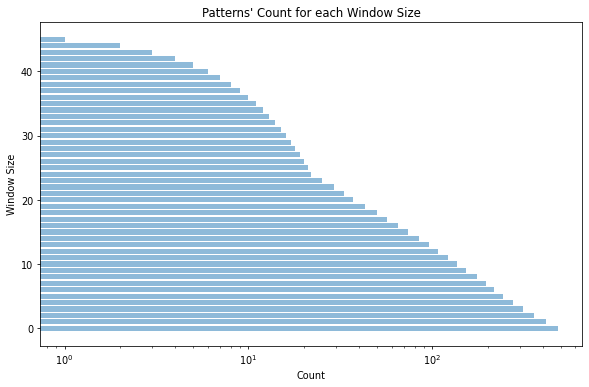

In [117]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

pattern_window_size = dic_count.keys()
y_pos = np.arange(len(pattern_window_size))

fig, ax = plt.subplots(figsize =(10, 6), dpi=70)
ax.barh(y_pos, pattern_count, align='center', alpha=0.5, log=True)

# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')

# Add Plot Title
ax.set_title('Patterns\' Count for each Window Size',loc ='center')
# ax.set_yticks(y_pos, objects)
ax.set_xlabel('Count')
ax.set_ylabel('Window Size')

plt.show()

### Approach (4): CC-Span

In [118]:
def append_to_dicc_new(dicc, vec_id, list_):
    if vec_id not in dicc:
        # key not exist
        dicc[vec_id] = list_
    else:
        # key exist
        for tuple_ in list_:
            for item in dicc[vec_id]:
                if item[0] == tuple_[0]:
                    item[1].append(tuple_[1][0])
                    break
    return dicc

In [119]:
# Searching Pattern
low = 10     # <~~~~~~~ define the lower bound threshold
up = len(uniqe_dic)
dicc = {}     

for i_v, vector in enumerate(_2D_array):    
    for index, element in enumerate(vector):
        list_ = []
        for wind_size in range(low, len(vector)+1-index):
            list_.append((wind_size, [(*vector[index:index+wind_size], )]))
        dicc = append_to_dicc_new(dicc, i_v, list_)    

In [120]:
# Counting
def remove_duplication(dup_list):
    final_list = []
    for item in dup_list:
        if item not in final_list:
            final_list.append(item)
        else:
            indx = final_list.index(item)
            counter = final_list[indx][0] + 1
            pair = final_list[indx][1]
            final_list.remove(item)
            final_list.append((counter, pair))
    
    return final_list

In [121]:
dic_count = {}

for vec_i, list_tuples in dicc.items():
#     print(vec_i, list_tuples,"\n")
    for tuples_ in list_tuples:
#         print(tuples_)
        
        if tuples_[0] not in dic_count:
            lst_ = [(1, tuple_) for tuple_ in tuples_[1]] 
            
            if len(lst_) != len(set(lst_)):
                lst_ = remove_duplication(lst_)
            
            dic_count[tuples_[0]] = lst_  
        else:
            #(2, [(1, 3), (1, 4), (3, 4), (4, 5), (5, 1)]
            #break
            for tuple_ in tuples_[1]:
                flag = 0 
                for item in dic_count[tuples_[0]]:
                    if item[1] == tuple_:
                        counter = item[0] + 1
                        dic_count[tuples_[0]].remove(item)
                        dic_count[tuples_[0]].append((counter, item[1]))
                        flag = 1
                        break
                # tuple is new
                if flag == 0:
                    dic_count[tuples_[0]].append((1, tuple_))
#                 else: 
#                     print("Error100")
#     print("salam", dic_count[2], "\n\n" )
#     if vec_i == 1:
#         break

# _2d_array = [[1, 3, 4, 3, 4, 5, 1, 4],
#              [1, 6, 3, 4, 5],
#              [1, 2, 6, 3],
#              [6, 1, 3, 4, 5],
#              [3, 4, 3, 6],
#              [2, 3, 1, 4, 6]]

In [122]:
def is_subsequence(needle: list, haystack: list) -> bool:
    # >>> is_subsequence([2, 3, 4], [1, 2, 3, 4, 5, 6])
    return any(
        haystack[i:i+len(needle)] == needle
        for i in range(len(haystack) - len(needle) + 1)
    )

In [123]:
def CloConSeqGen(dic_count: dict, threshold: int) -> list:
    closed_list = []
    for key, v_list in dic_count.items():
        #print(key, v_list)
        for item_tup in v_list:
            tmp_flag = False
            for key, v_list_search in dic_count.items():
                for item_tup_search in v_list_search:
                    #print("compare with: ", item_tup_search[1])
                    if len(item_tup_search[1]) >= len(item_tup[1]) and is_subsequence(item_tup[1], item_tup_search[1]) and item_tup[1] != item_tup_search[1]:
                        if item_tup[0] == item_tup_search[0]:
                            tmp_flag = True
            if not tmp_flag and item_tup[0] > threshold:

                closed_list.append(item_tup)
    return closed_list

In [124]:
dic_count.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55])

In [125]:
def CloConSeqGen_v2(dic_count: dict) -> list:
    closed_list = []
    flag_first_step = True
    for win_size in list(reversed(list(dic_count))):
        # Just add the last or the biggest window_size to the list 
        if flag_first_step:
            flag_first_step = False
            for item in dic_count[win_size]:
                closed_list.append(item)
            continue
        
        # For other window sizes
        for item_tup_new in dic_count[win_size]:
            flag_visit = False
            for item_tup_old in closed_list:
                if item_tup_new[0] == item_tup_old[0] and is_subsequence(item_tup_new[1], item_tup_old[1]):
                    flag_visit = True
                    break
            if not flag_visit:
                closed_list.append(item_tup_new)

    return len(closed_list)

In [126]:
def CloConSeqGen_v3(dic_count: dict, threshold: int) -> list:
    closed_list = []
    flag_first_step = True
    for win_size in list(reversed(list(dic_count))):
        # Just add the last or the biggest window_size to the list 
        if flag_first_step:
            for item in dic_count[win_size]:
                if item[0] >= threshold:
                    flag_first_step = False
                    closed_list.append(item)
            continue
        
        # For other window sizes
        for item_tup_new in dic_count[win_size]:
            flag_visit = False
            for item_tup_old in closed_list:
                if item_tup_new[0] == item_tup_old[0] and is_subsequence(item_tup_new[1], item_tup_old[1]):
                    flag_visit = True
                    break
            if (not flag_visit) and (item_tup_new[0] >= threshold):
                closed_list.append(item_tup_new)

    return len(closed_list)

In [127]:
print(CloConSeqGen_v2(dic_count))
print(CloConSeqGen_v3(dic_count, 1))
print(CloConSeqGen_v3(dic_count, 5))

81
81
5


### Approach (5):

In this method, we tried to find pattern based on the dic, so it is super time-consuming.

In [111]:
# def append_to_dicc(dicc, indx_vec, pair_size, item):
#     list_permut_tuples = dicc[indx_vec]
#     flag = 0
#     for tuple_per in list_permut_tuples:
#         if tuple_per[0] == pair_size:
#             flag = 1
#             # check
#             if item in set(tuple_per[1]):
#                 print("Error1")
#             else:
# #                 print("old")
#                 tuple_per[1].append(item)
#             break
#     if flag == 0:
# #         arr = []
# #         arr.append(item)
# #         print("new")
#         dicc[indx_vec].append((pair_size, item))
#     return dicc 

In [110]:
# def get_extended_permut(uniqe_dic, list_tuples):
#     list_ = []
#     for element in list_tuples:
#         for key in uniqe_dic:
#             list_.append((*element, key))
#     return list_

In [109]:
# def get_permut_from_dic(dicc, index_vec, pair_size):
#     for tuple_item in dicc[index_vec]:
#         if tuple_item[0] == pair_size:
#             return tuple_item[1]
#     return []

In [73]:
# low = 2
# up = len(uniqe_dic)
# dicc = {} 

# for m in range(low, up+1):
    
#     for i_v, vector in enumerate(_2D_array):
# #         print("\nvec ", vector)
#         list_ = []
#         flag = 0
#         if m == low:
#             permut_list = list(permutations(uniqe_dic.keys(), m))
#         else:
#             permut_pre = get_permut_from_dic(dicc, i_v, m-1)
#             if not permut_pre:
#                 # There is no pairs for the previous combination
# #                 print("\n\nsalam\n\n", m)
#                 continue
#             permut_list = get_extended_permut(uniqe_dic , permut_pre)
        
# #         print("Per list: ", permut_list)
# #         print("Dicc curent: ", dicc)
        
#         for pair in permut_list:
# #             print(pair)
#             for idx, element_str in enumerate(vector):   
#                 if element_str == pair[0]:
#                     if (idx+len(pair)) <= len(vector): 
#                         for i_p in range(0, len(pair)):
#                             if pair[i_p] != vector[idx+i_p]:
#                                 flag = 1
#                                 break
#                         if flag == 0:
#                             list_.append(pair)
#                         flag = 0
#         # insert to dic
#         if m == low:
#             dicc[i_v] = [(len(pair), list_)]
#         else:
#             # List not empty
#             if list_:
#                 #print("sa ", list_)
#                 dicc = append_to_dicc(dicc, i_v, len(pair), list_)
#             #print(dicc)

# #         print(dicc)
# #     if m == low+1:
# #         break

In [74]:
#_2D_array_pad = numpy_fillna(_2D_array)

In [75]:
#_2D_array_pad.shape

In [76]:
# print(f"The number of entire stack traces is {_2D_array_pad.shape[0]} and the maximum number of pairs in a stack trase is {_2D_array_pad.shape[1]}.")

## Answer time

### Loading Answer Dataset

In [77]:
# pure_ans_data = working_directory_path + "ansSample.csv"
# path_ans = Path(pure_ans_data)

# if path_ans.suffix == ".csv":
#     df_ans = pd.read_csv(path_ans, encoding=encoding)
# else:
#     raise ValueError("{data_file_path.suffix} extensions are not supported")

## Create DF based on the questions contain stack traces

In [128]:
df_status_w_stack = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

In [129]:
df_status_w_stack["Q_info"] = Question_with_trace_info

In [130]:
Question_with_trace_info[0]

(53588623, '2018-12-03 06:35:18', 5508, 1, 0, 2, 53592537.0)

In [131]:
df_status_w_stack["Q_id"]          = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[0])
df_status_w_stack["Q_create_time"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[1])
df_status_w_stack["View_count"]    = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[2])
df_status_w_stack["Answer_count"]  = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[3])
df_status_w_stack["Comment_count"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[4])
df_status_w_stack["Score"]         = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[5])
df_status_w_stack["Accepted_Answer_id"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[6])

In [132]:
df_status_w_stack = df_status_w_stack.drop(['Q_info'], axis='columns')

In [133]:
df_status_w_stack["Q_create_time"]      = pd.to_datetime(df_status_w_stack["Q_create_time"])
df_status_w_stack["First_acc_ans_time"] = pd.to_datetime(df_status_w_stack["First_acc_ans_time"])
df_status_w_stack["First_ans_time"]     = pd.to_datetime(df_status_w_stack["First_ans_time"])

#### Filling the Answers column: A list contains the id and time of answers

In [153]:
pure_data = working_directory_path + "PT_w_stack_result_DB.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [154]:
df_status_w_stack['Answers'] = df_status_w_stack.apply(lambda x: [], axis=1)

We have to prepare and find answers that has Pytorch parrentID, so first we catch the questions and store as table in DB. Before this job we have to create a table with all answrs and apply inner join to those tables:

In [155]:
for index1, row_status in df_status_w_stack.iterrows():
    for index2, row_night in df_night.iterrows():
            if row_night["ParentId"] == row_status["Q_id"]:
                    row_status['Answers'].append((row_night["Id"], row_night["CreationDate"]))

In [156]:
df_status_w_stack["Answers"] = df_status_w_stack["Answers"].apply(lambda answers_list: list(set(answers_list)))

In [157]:
df_night

,Q_id,Id,CreationDate,ParentId
0,53588623,53592537,2018-12-03 11:07:23,53588623
1,55762581,55763110,2019-04-19 14:04:51,55762581
2,62677285,62678431,2020-07-01 13:53:06,62677285
3,62677285,62680230,2020-07-01 15:29:24,62677285
4,46509039,46565802,2017-10-04 13:11:59,46509039
...,...,...,...,...
656,60771047,60771714,2020-03-20 09:43:21,60771047
657,59378742,59397454,2019-12-18 17:39:37,59378742
658,49161652,49253755,2018-03-13 10:27:35,49161652
659,49161652,49316176,2018-03-16 08:30:40,49161652


In [158]:
# df_night[df_night["ParentId"]== 62677285]
df_night.head()

,Q_id,Id,CreationDate,ParentId
0,53588623,53592537,2018-12-03 11:07:23,53588623
1,55762581,55763110,2019-04-19 14:04:51,55762581
2,62677285,62678431,2020-07-01 13:53:06,62677285
3,62677285,62680230,2020-07-01 15:29:24,62677285
4,46509039,46565802,2017-10-04 13:11:59,46509039


In [159]:
def checker_1(i, answers_list, answers_count):
    global counter
    if len(answers_list) != answers_count:
        print("Error ", i, len(answers_list), answers_count)

In [160]:
df_status_w_stack.apply(lambda row: checker_1(row.name, row.Answers, row.Answer_count), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
706    None
707    None
708    None
709    None
710    None
Length: 711, dtype: object

In [161]:
for index1, row_status in df_status_w_stack.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answers"]:
        # print("is empty")
        continue

    for answer in row_status["Answers"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    df_status_w_stack.at[index1,'First_ans_time'] = fr_time
    df_status_w_stack.at[index1,'First_acc_ans_time'] = acc_time

In [162]:
df_status_w_stack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   First_ans_time      490 non-null    datetime64[ns]
 1   First_acc_ans_time  490 non-null    datetime64[ns]
 2   Answers             711 non-null    object        
 3   Q_id                711 non-null    int64         
 4   Q_create_time       711 non-null    datetime64[ns]
 5   View_count          711 non-null    int64         
 6   Answer_count        711 non-null    int64         
 7   Comment_count       711 non-null    int64         
 8   Score               711 non-null    int64         
 9   Accepted_Answer_id  270 non-null    float64       
dtypes: datetime64[ns](3), float64(1), int64(5), object(1)
memory usage: 55.7+ KB


Write df_status_w_stack to the CSV file:

In [163]:
df_status_w_stack.to_csv('./status_PT_df_w_stack_with_list_of_answers_col.csv', encoding='utf-8')

Read df_status_w_stack from the CSV file:

In [164]:
# df_status_w_stack = pd.read_csv('./status_df_w_stack_with_list_of_answers_col.csv', encoding=encoding)

In [165]:
df_status_w_stack["Duration_ans"] = df_status_w_stack.apply(lambda row: (row.First_ans_time-row.Q_create_time).days, axis=1)
df_status_w_stack["Duration_acc_ans"] = df_status_w_stack.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).days, axis=1)

In [166]:
df_status_w_stack['Duration_ans'] = df_status_w_stack['Duration_ans'].fillna(0)
df_status_w_stack['Duration_acc_ans'] = df_status_w_stack['Duration_acc_ans'].fillna(0)

In [167]:
df_status_w_stack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   First_ans_time      490 non-null    datetime64[ns]
 1   First_acc_ans_time  490 non-null    datetime64[ns]
 2   Answers             711 non-null    object        
 3   Q_id                711 non-null    int64         
 4   Q_create_time       711 non-null    datetime64[ns]
 5   View_count          711 non-null    int64         
 6   Answer_count        711 non-null    int64         
 7   Comment_count       711 non-null    int64         
 8   Score               711 non-null    int64         
 9   Accepted_Answer_id  270 non-null    float64       
 10  Duration_ans        711 non-null    float64       
 11  Duration_acc_ans    711 non-null    float64       
dtypes: datetime64[ns](3), float64(3), int64(5), object(1)
memory usage: 66.8+ KB


In [168]:
df_status_w_stack.shape

(711, 12)

In [169]:
df_status_w_stack.describe()

,Q_id,View_count,Answer_count,Comment_count,Score,Accepted_Answer_id,Duration_ans,Duration_acc_ans
count,7.110000e+02,711.000000,711.000000,711.000000,711.000000,2.700000e+02,711.000000,711.000000
mean,5.865697e+07,1300.334740,0.929677,1.476793,1.136428,5.813700e+07,11.578059,280.711674
std,5.132569e+06,2441.470025,0.837908,2.335087,2.105582,5.126831e+06,52.685907,456.310720
min,4.308058e+07,10.000000,0.000000,0.000000,-3.000000,4.308078e+07,0.000000,0.000000
25%,5.540812e+07,88.500000,0.000000,0.000000,0.000000,5.405702e+07,0.000000,0.000000
50%,6.006716e+07,345.000000,1.000000,0.000000,0.000000,5.963381e+07,0.000000,0.000000
75%,6.273625e+07,1243.000000,1.000000,2.000000,1.000000,6.227362e+07,0.000000,578.500000
max,6.514435e+07,16365.000000,6.000000,18.000000,13.000000,6.510828e+07,549.000000,1788.000000


## Create DF based on the questions do not have stack traces

We have to prepare and find answers that has Pytorch parrentID, so first we catch the questions and store as table in DB. Before this job we have to create a table with all answrs and apply inner join to those tables:

In [187]:
# df_status_wo_stack["Q_id"].to_csv('./df_PT_wo_stack.csv', encoding='utf-8')

KeyError: "['Id', 'CreationDate'] not in index"

In [196]:
pure_data = working_directory_path + "PT_wo_stack_result_DB.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night_wo = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [200]:
df_night_wo.shape

(3855, 4)

In [198]:
df_night_wo.head()

,Q_id,Id,CreationDate,ParentId
0,52948410,52953192,2018-10-23 15:51:48,52948410
1,63522070,63522987,2020-08-21 12:31:12,63522070
2,63522070,63523010,2020-08-21 12:32:21,63522070
3,64355180,64355411,2020-10-14 14:23:32,64355180
4,57753687,57754054,2019-09-02 08:56:17,57753687


In [199]:
# df_night_wo.drop_duplicates(["Q_id", "Id", "ParentId", "CreationDate"], ignore_index=False, inplace=True)
df_night_wo = df_night_wo.reset_index(drop=True)

In [201]:
df_status_wo_stack = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

df_status_wo_stack["Q_info"] = Question_with_wo_trace_info

df_status_wo_stack["Q_id"]          = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[0])
df_status_wo_stack["Q_create_time"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[1])
df_status_wo_stack["View_count"]    = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[2])
df_status_wo_stack["Answer_count"]  = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[3])
df_status_wo_stack["Comment_count"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[4])
df_status_wo_stack["Score"]         = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[5])
df_status_wo_stack["Accepted_Answer_id"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[6])

df_status_wo_stack = df_status_wo_stack.drop(['Q_info'], axis='columns')

df_status_wo_stack["Q_create_time"] = pd.to_datetime(df_status_wo_stack["Q_create_time"])
df_status_wo_stack["First_acc_ans_time"] = pd.to_datetime(df_status_wo_stack["First_acc_ans_time"])
df_status_wo_stack["First_ans_time"]     = pd.to_datetime(df_status_wo_stack["First_ans_time"])

In [202]:
df_night_wo.head()

,Q_id,Id,CreationDate,ParentId
0,52948410,52953192,2018-10-23 15:51:48,52948410
1,63522070,63522987,2020-08-21 12:31:12,63522070
2,63522070,63523010,2020-08-21 12:32:21,63522070
3,64355180,64355411,2020-10-14 14:23:32,64355180
4,57753687,57754054,2019-09-02 08:56:17,57753687


In [203]:
df_status_wo_stack.head()

,First_ans_time,First_acc_ans_time,Answers,Q_id,Q_create_time,View_count,Answer_count,Comment_count,Score,Accepted_Answer_id
0,NaT,NaT,NaN,63831906,2020-09-10 14:30:09,73,0,2,0,NaN
1,NaT,NaT,NaN,52948410,2018-10-23 11:51:54,226,1,2,-1,NaN
2,NaT,NaT,NaN,63522070,2020-08-21 11:29:49,62,2,1,0,63523010.0
3,NaT,NaT,NaN,64355180,2020-10-14 14:11:14,38,1,0,1,64355411.0
4,NaT,NaT,NaN,57753687,2019-09-02 08:29:42,285,1,2,1,NaN


In [204]:
df_status_wo_stack['Answers'] = df_status_wo_stack.apply(lambda x: [], axis=1)

In [205]:
df_night_wo.shape

(3855, 4)

In [206]:
df_status_wo_stack.shape

(3903, 10)

In [207]:
# # It is super time-consuming and never run!
# for index1, row_status in df_status_wo_stack.iterrows():
#     for index2, row_night in df_night_wo.iterrows():
#         if row_night["ParentId"] == row_status["Q_id"]:
#                 row_status['Answers'].append((row_night["Id"], row_night["CreationDate"]))

In [208]:
pd_tmp = pd.merge(df_status_wo_stack, df_night_wo, how='left',left_on=['Q_id'],right_on=['ParentId']).reset_index(drop=True)

In [209]:
pd_tmp["Answer_tup"] = pd_tmp.apply(lambda x: (x.Id, x.CreationDate), axis=1)

In [210]:
# pd_tmp_new = pd_tmp.groupby(["First_ans_time", "First_acc_ans_time", "Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count", "Accepted_Answer_id"])["Answer_tup"].agg(list).reset_index()
pd_tmp_new = pd_tmp.groupby(["Q_id_x", "Q_create_time", "View_count", "Comment_count", "Score", "Answer_count"])["Answer_tup"].agg(list).reset_index()

In [211]:
pd_tmp_new2 = pd_tmp_new[pd_tmp_new.Answer_count != 0].reset_index(drop=True)

In [212]:
def checker_ans_and_ans_tup(row_indx: int, ans_count: int, ans_list: list) -> None:
    if len(ans_list) != ans_count:
        print("Error!: ", row_indx, ans_count, ans_list)

In [213]:
# We checked all Q_id_x are unique
pd_tmp_new2.apply(lambda row: checker_ans_and_ans_tup(row.name, row.Answer_count, row.Answer_tup), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1660    None
1661    None
1662    None
1663    None
1664    None
Length: 1665, dtype: object

In [214]:
# df_status_wo_stack["Answers"] = df_status_wo_stack["Answers"].apply(lambda answers_list: list(set(answers_list)))

In [215]:
# df_status_wo_stack.apply(lambda row: checker_1(row.name, row.Answers, row.Answer_count), axis=1)

In [216]:
df_status_wo_stack.head()

,First_ans_time,First_acc_ans_time,Answers,Q_id,Q_create_time,View_count,Answer_count,Comment_count,Score,Accepted_Answer_id
0,NaT,NaT,[],63831906,2020-09-10 14:30:09,73,0,2,0,NaN
1,NaT,NaT,[],52948410,2018-10-23 11:51:54,226,1,2,-1,NaN
2,NaT,NaT,[],63522070,2020-08-21 11:29:49,62,2,1,0,63523010.0
3,NaT,NaT,[],64355180,2020-10-14 14:11:14,38,1,0,1,64355411.0
4,NaT,NaT,[],57753687,2019-09-02 08:29:42,285,1,2,1,NaN


In [217]:
pd_tmp_new2.head()

,Q_id_x,Q_create_time,View_count,Comment_count,Score,Answer_count,Accepted_Answer_id,Answer_tup
0,42479902,2017-02-27 07:21:10,156271,0,234,8,42482819.0,"[(42482819.0, 2017-02-27 10:04:35), (48650355.0, 2018-02-06 19:15:51), (54687473.0, 2019-02-14 09:49:56), (55155611.0, 2019-03-14 05:37:30), (55880999.0, 2019-04-27 13:22:18), (58897267.0, 2019-11-17 03:34:35), (59961625.0, 2020-01-29 06:35:10), (62305146.0, 2020-06-10 13:44:11)]"
1,42480111,2017-02-27 07:35:42,97258,2,148,12,42616812.0,"[(42612738.0, 2017-03-05 19:09:50), (42616812.0, 2017-03-06 02:55:06), (45528544.0, 2017-08-06 04:33:59), (48659275.0, 2018-02-07 08:39:26), (49989438.0, 2018-04-23 20:26:58), (54581226.0, 2019-02-07 19:50:57), (56762410.0, 2019-06-25 21:43:16), (59164576.0, 2019-12-03 20:07:48), (59360340.0, 2019-12-16 16:12:47), (59696639.0, 2020-01-11 17:03:03), (63372506.0, 2020-08-12 08:15:31), (64356245.0, 2020-10-14 15:06:38)]"
2,42711144,2017-03-10 05:47:28,18672,0,16,7,42735403.0,"[(42735403.0, 2017-03-11 12:48:46), (47667283.0, 2017-12-06 05:18:11), (48843779.0, 2018-02-17 17:07:34), (55081539.0, 2019-03-09 20:14:50), (61544999.0, 2020-05-01 15:01:10), (62297965.0, 2020-06-10 07:24:15), (62300335.0, 2020-06-10 09:35:04)]"
3,43328632,2017-04-10 16:38:52,111634,0,44,10,43451081.0,"[(43344607.0, 2017-04-11 11:27:11), (43451081.0, 2017-04-17 12:01:28), (46627181.0, 2017-10-08 03:13:51), (47561301.0, 2017-11-29 20:30:25), (47667447.0, 2017-12-06 05:32:27), (53490192.0, 2018-11-26 22:39:13), (54242870.0, 2019-01-17 19:20:17), (59603631.0, 2020-01-05 19:48:49), (60492939.0, 2020-03-02 16:27:15), (64006971.0, 2020-09-22 09:34:59)]"
4,43779500,2017-05-04 09:50:44,11499,1,3,2,43779600.0,"[(43779546.0, 2017-05-04 09:52:56), (43779600.0, 2017-05-04 09:55:24)]"


In [218]:
pd_tmp_new2.insert(len(pd_tmp_new2.columns), 'First_ans_time', np.nan)
pd_tmp_new2.insert(len(pd_tmp_new2.columns), 'First_acc_ans_time', np.nan)

In [219]:
pd_tmp_new3 = pd_tmp_new2.copy()

In [220]:
for index1, row_status in pd_tmp_new3.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answer_tup"]:
        # print("is empty")
        continue

    for answer in row_status["Answer_tup"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    pd_tmp_new3.at[index1,'First_ans_time'] = fr_time
    pd_tmp_new3.at[index1,'First_acc_ans_time'] = acc_time

In [320]:
pd_tmp_new3["Duration_ans"] = pd_tmp_new3.apply(lambda row: (row.First_ans_time-row.Q_create_time).total_seconds()/3600, axis=1)
pd_tmp_new3["Duration_acc_ans"] = pd_tmp_new3.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).total_seconds()/3600, axis=1)

In [321]:
pd_tmp_new3['Duration_ans'] = pd_tmp_new3['Duration_ans'].fillna(0)
pd_tmp_new3['Duration_acc_ans'] = pd_tmp_new3['Duration_acc_ans'].fillna(0)

In [223]:
# pd_tmp_new3.to_csv('./wo_otagh_toolani.csv', encoding='utf-8')

### Find the durarion of answers

In [322]:
# We have to delete rows or posts that doesn't have answer, because their zero values affect the meadian value (or the box plot values):
df_status_w_stack_filtered = df_status_w_stack[df_status_w_stack["Answer_count"] > 0]
pd_tmp_new3_filtered = pd_tmp_new3[pd_tmp_new3["Answer_count"] > 0]

In [323]:
pd_tmp_new3[["Q_create_time", "First_ans_time", "Answer_count", "Duration_ans"]].head(500)

,Q_create_time,First_ans_time,Answer_count,Duration_ans
0,2017-02-27 07:21:10,2017-02-27 10:04:35,8,2.723611
1,2017-02-27 07:35:42,2017-03-05 19:09:50,12,155.568889
2,2017-03-10 05:47:28,2017-03-11 12:48:46,7,31.021667
3,2017-04-10 16:38:52,2017-04-11 11:27:11,10,18.805278
4,2017-05-04 09:50:44,2017-05-04 09:52:56,2,0.036667
5,2017-05-14 09:57:10,2017-05-23 09:33:20,2,215.602778
6,2017-05-15 21:48:04,2017-05-17 09:44:36,2,35.942222
7,2017-05-31 12:12:31,2017-06-01 19:00:51,3,30.805556
8,2017-06-04 17:45:32,2017-06-04 18:36:39,2,0.851944
9,2017-06-07 06:40:24,2017-06-15 15:48:10,1,201.129444


In [324]:
pd_tmp_new3[["Q_create_time", "First_ans_time", "Answer_count", "Duration_ans"]].describe()

,Answer_count,Duration_ans
count,1665.000000,1665.000000
mean,1.381982,95.794311
std,0.891014,585.233515
min,1.000000,0.000000
25%,1.000000,0.452778
50%,1.000000,1.864444
75%,2.000000,10.161667
max,17.000000,12338.200278


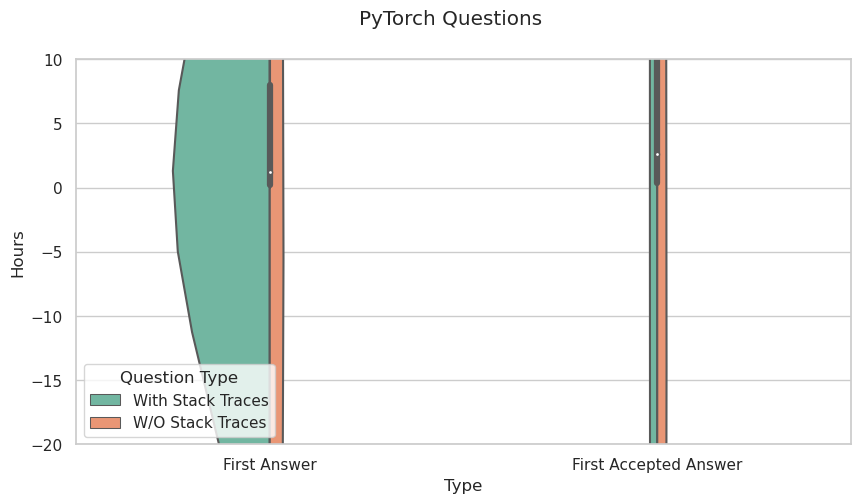

In [325]:
# Example:
sns.set_theme(style="whitegrid")

# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_1['Hours'] = df_status_w_stack_filtered['Duration_ans']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "With Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_2['Hours'] = pd_tmp_new3_filtered['Duration_ans']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "W/O Stack Traces")

resultComment = pd.concat([df_1, df_2])
resultComment['Type'] = "First Answer"
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_1['Hours'] = df_status_w_stack_filtered['Duration_acc_ans']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "With Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Hours'])
df_2['Hours'] = pd_tmp_new3_filtered['Duration_acc_ans']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "W/O Stack Traces")

resultAnswer = pd.concat([df_1, df_2])
resultAnswer['Type'] = "First Accepted Answer"
# ###################################################################################

result = pd.concat([resultComment, resultAnswer], ignore_index=True)

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Hours", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               # scale="count",
               # inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-20,10)
# plt.xlim(-1,1)

fig.suptitle('PyTorch Questions')
# fig.suptitle('TensorFlow Questions', prop={"size":10})
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.legend(loc='upper left')

plt.show()

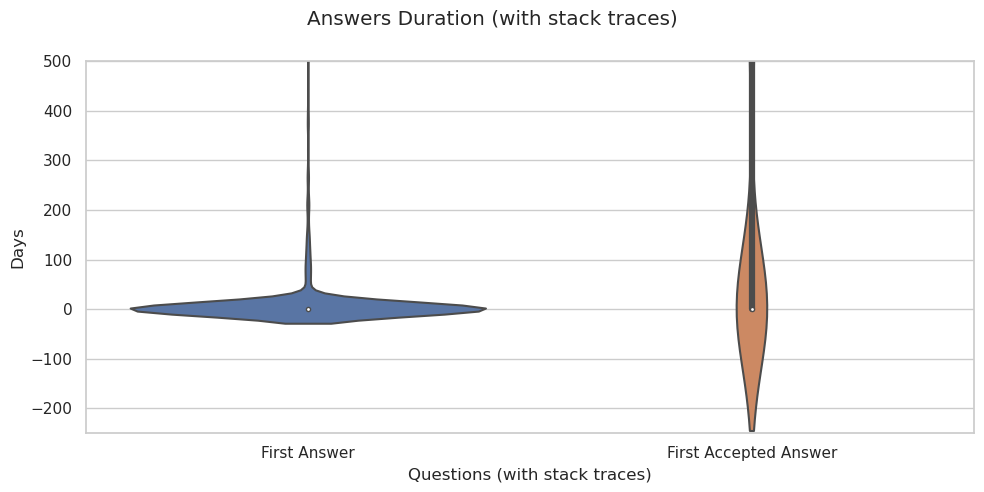

In [253]:
df_1 = pd.DataFrame(columns=['Questions (with stack traces)', 'Days'])
df_1['Days'] = df_status_w_stack['Duration_ans']
df_1['Questions (with stack traces)'] = df_1['Questions (with stack traces)'].apply(lambda x: "First Answer")

df_2 = pd.DataFrame(columns=['Questions (with stack traces)', 'Days'])
df_2['Days'] = df_status_w_stack['Duration_acc_ans']
df_2['Questions (with stack traces)'] = df_2['Questions (with stack traces)'].apply(lambda x: "First Accepted Answer")

result = pd.concat([df_1, df_2])

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x=result["Questions (with stack traces)"], y=result["Days"])

plt.ylim(-250,500)

# fig = plt.figure(figsize=(10, 5))
# gs = fig.add_gridspec(1, 2)

# # min_ = min(min(df_status_w_stack['Duration_ans']), min(df_status_w_stack['Duration_acc_ans']))
# # max_ = max(max(df_status_w_stack['Duration_ans']), max(df_status_w_stack['Duration_acc_ans']))

# ax1 = fig.add_subplot(gs[0, 0])
# sns.violinplot(data=df_status_w_stack['Duration_ans'])
# ax1.set_xlabel("First Answer")
# ax1.set_ylabel("Day")
# # ax1 = plt.ylim(min_,max_)

# ax2 = fig.add_subplot(gs[0, 1])
# sns.violinplot(data=df_status_w_stack['Duration_acc_ans'])
# ax2.set_xlabel("First Accepted Answer")
# ax2.set_ylabel("Day")
# # ax2 = plt.ylim(min_,max_)

fig.suptitle('Answers Duration (with stack traces)')

fig.tight_layout()
plt.show()

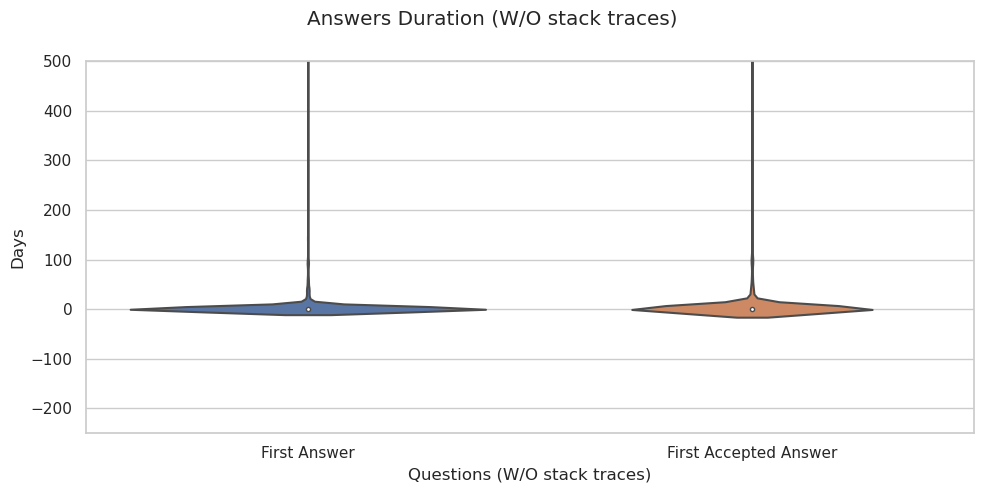

In [254]:
df_1 = pd.DataFrame(columns=['Questions (W/O stack traces)', 'Days'])
df_1['Days'] = pd_tmp_new3['Duration_ans']
df_1['Questions (W/O stack traces)'] = df_1['Questions (W/O stack traces)'].apply(lambda x: "First Answer")

df_2 = pd.DataFrame(columns=['Questions (W/O stack traces)', 'Days'])
df_2['Days'] = pd_tmp_new3['Duration_acc_ans']
df_2['Questions (W/O stack traces)'] = df_2['Questions (W/O stack traces)'].apply(lambda x: "First Accepted Answer")

result = pd.concat([df_1, df_2])

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x=result["Questions (W/O stack traces)"], y=result["Days"])

plt.ylim(-250,500)

fig.suptitle('Answers Duration (W/O stack traces)')

fig.tight_layout()
plt.show()

## Statistics Information

In [226]:
print("Question Numbers with all ML tags: ", df.shape[0])

Question Numbers with all ML tags:  163194


In [3]:
print("Question Numbers (with Tensorflow tags): ", df_w_Tens_tags.shape[0])

NameError: name 'df_w_Tens_tags' is not defined

In [228]:
print("Question Numbers (without Tensorflow tags): ", df.shape[0] - df_w_Tens_tags.shape[0])

Question Numbers (without Tensorflow tags):  157031


In [229]:
print("Tensorflow Question Numbers (with code): ", coun_w_c)
print("Tensorflow Question Numbers (without code): ", coun_wo_c)

Tensorflow Question Numbers (with code):  5083
Tensorflow Question Numbers (without code):  1080


In [230]:
print("Tensorflow Question Numbers (with code) have stack trace: ", count_w_t)
print("Tensorflow Question Numbers (with code) that doesn't have stack trace: ",count_wo_t-27)

Tensorflow Question Numbers (with code) have stack trace:  711
Tensorflow Question Numbers (with code) that doesn't have stack trace:  3876


In [231]:
print("Tensorflow Question Numbers (with stack trace:) on Unix based systems: ", count_unix)
print("Tensorflow Question Numbers (with stack trace:) on Windows based systems: ", count_win)

Tensorflow Question Numbers (with stack trace:) on Unix based systems:  541
Tensorflow Question Numbers (with stack trace:) on Windows based systems:  170


In [233]:
line_count_unix   = 0
line_count_win    = 0
line_count_simple = 0

for tuple in df_w_PT_tags["Line_code_u_w_s"]:
    line_count_unix   += tuple[0]
    line_count_win    += tuple[1]
    line_count_simple += tuple[2]
        
print(f"The total number of line codes in the body part (w/o stack trace) is {line_count_simple}.")
print(f"The total LOC amongst stack traces is {line_count_unix} (Unix-based reports).")
print(f"The total LOC amongst stack traces is {line_count_win} (Windows-based reports).")
print(f"The total LOC amongst stack traces is {line_count_unix+line_count_win}.")

The total number of line codes in the body part (w/o stack trace) is 187947.
The total LOC amongst stack traces is 7421 (Unix-based reports).
The total LOC amongst stack traces is 2585 (Windows-based reports).
The total LOC amongst stack traces is 10006.


In [234]:
print(f"We found {max(dic.values())} unique pairs in stack traces posts related to the Tensorflow frameworks.")

We found 1337 unique pairs in stack traces posts related to the Tensorflow frameworks.


## Graphical Results

### LOC

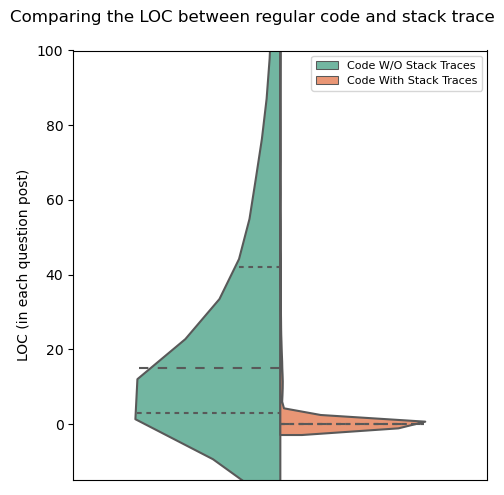

In [236]:
code_wo_trace = df_w_PT_tags["Line_code_simple_code"]
code_w_trace_w = df_w_PT_tags["Line_code_win"]
code_w_trace_u = df_w_PT_tags["Line_code_uix"]
code_w_trace = df_w_PT_tags["Line_code_win"] + df_w_PT_tags["Line_code_uix"]

df_1 = pd.DataFrame(columns=['Questions', 'LOC (in each question post)'])
df_1['LOC (in each question post)'] = code_wo_trace
df_1['Questions'] = df_1['Questions'].apply(lambda x: "Code W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Questions', 'LOC (in each question post)'])
df_2['LOC (in each question post)'] = code_w_trace
df_2['Questions'] = df_2['Questions'].apply(lambda x: "Code With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="LOC (in each question post)", 
               data=result, 
               hue="Questions", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(-15, 100)
# plt.xlim(-1, 1)

fig.suptitle('Comparing the LOC between regular code and stack trace')

plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":8})
fig.tight_layout()

plt.show()

### Question Length

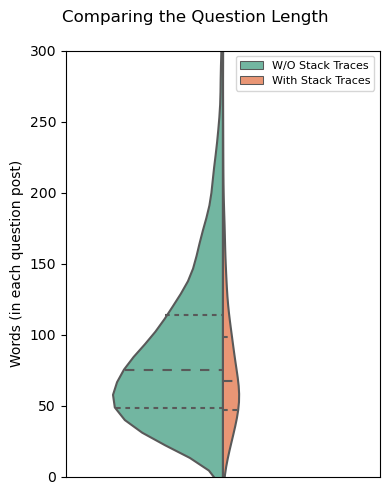

In [237]:
df_1 = pd.DataFrame(columns=['Question Length', 'Words (in each question post)'])
df_1['Words (in each question post)'] = list_num_words_wo_tra
df_1['Question Length'] = df_1['Question Length'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Length', 'Words (in each question post)'])
df_2['Words (in each question post)'] = list_num_words_w_tra
df_2['Question Length'] = df_2['Question Length'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(4, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Words (in each question post)", 
               data=result, 
               hue="Question Length", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(0, 300)
# plt.xlim(-1, 1)

fig.suptitle('Comparing the Question Length')

plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":8})
fig.tight_layout()

plt.show()

### Plotting Score, View, Answer, Comment Counts 

In [238]:
def get_sturges_rule_number(n_obser: int) -> int:
    '''
    Sturges’ Rule is the most common method for determining the optimal number of bins.

    Parameters:
    ----------
    n_obser : int
        The total number of observations in the dataset.

    Returns:
    ----------
    Use ⌈ ⌉ for returning a value: Symbols that mean “ceiling” – i.e. round the answer up to
    the nearest integer.
    '''
    # return round(1 + math.log2(n_obser))
    return round(np.ceil(1 + (3.322 * np.log10(n_obser))))

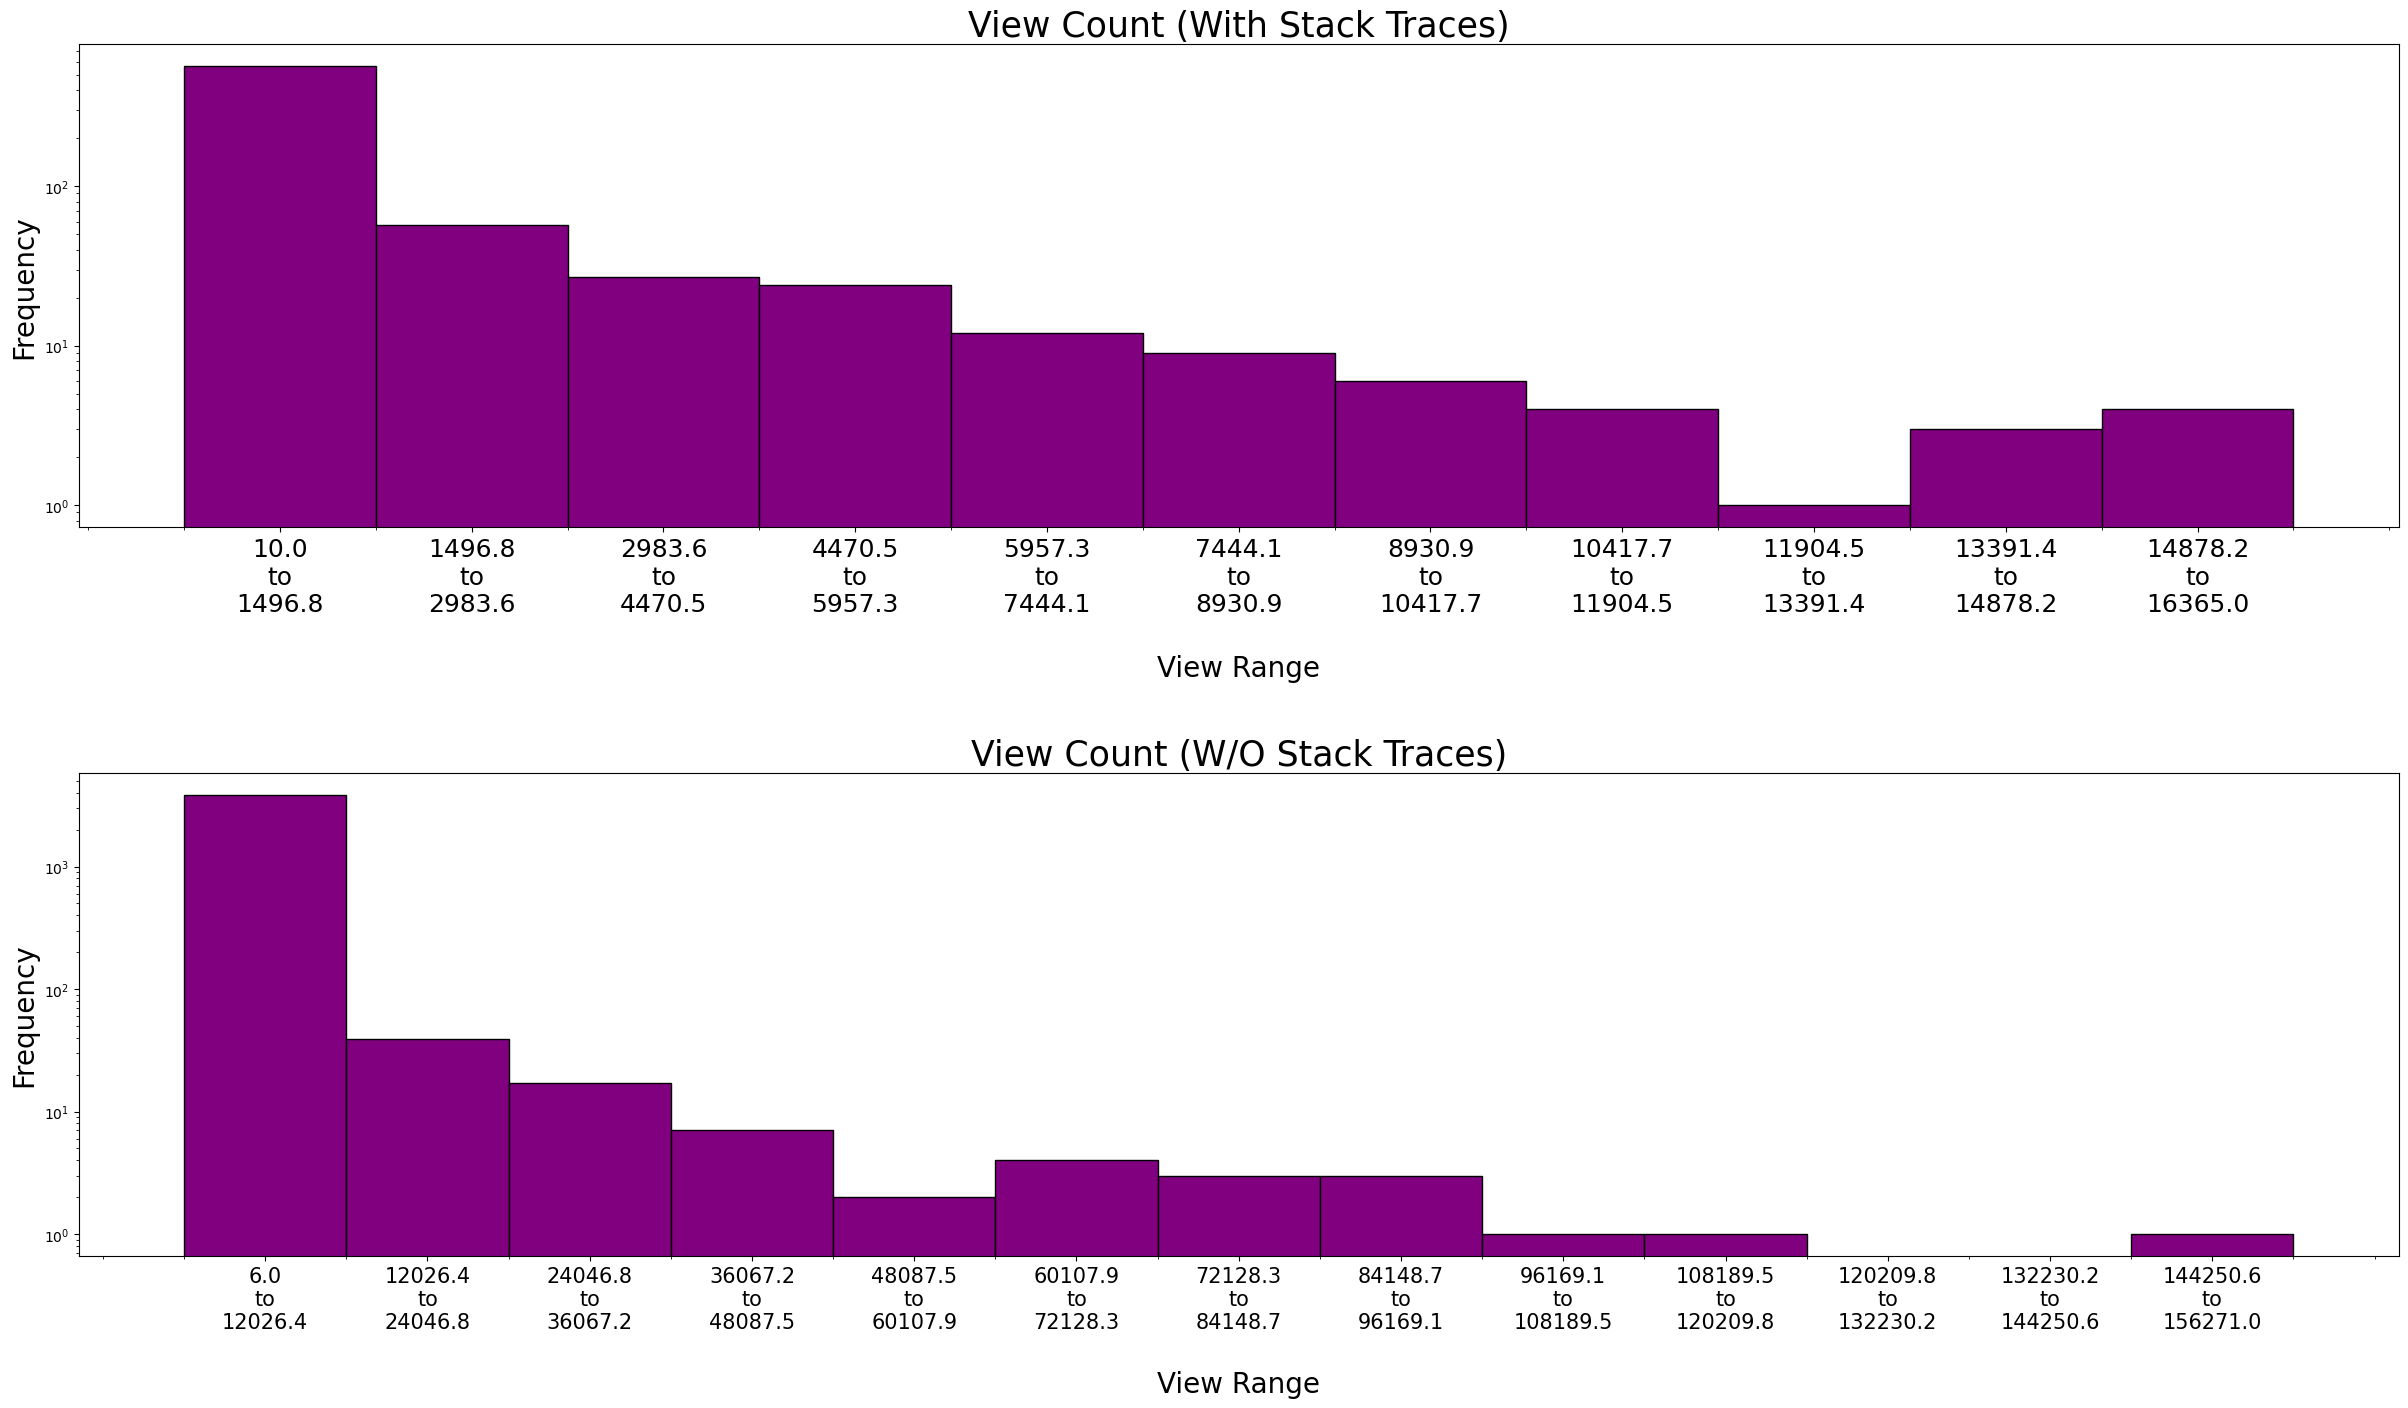

In [239]:
plt.figure(figsize=[25,15])
plt.subplot(211)

plt.title('View Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nView Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['View_count']))

n, bins, patches = plt.hist(df_status_w_stack['View_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='purple', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(False)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)


plt.subplot(212)

plt.title('View Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nView Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['View_count']))

n, bins, patches = plt.hist(df_status_wo_stack['View_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='purple', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=15)

plt.tight_layout(pad=4.0)
plt.show()

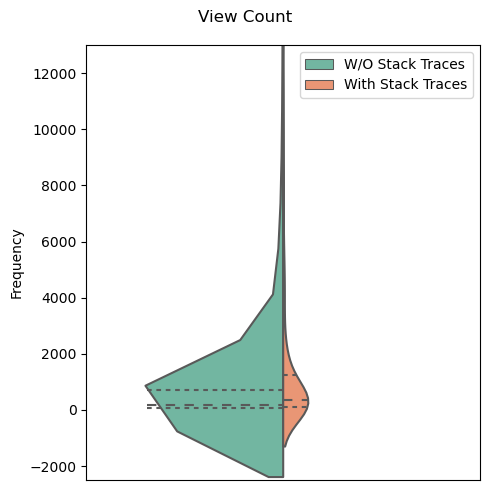

In [240]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['View_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['View_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(-2500,13000)
# plt.xlim(-1,1)

fig.suptitle('View Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})
fig.tight_layout()
plt.show()

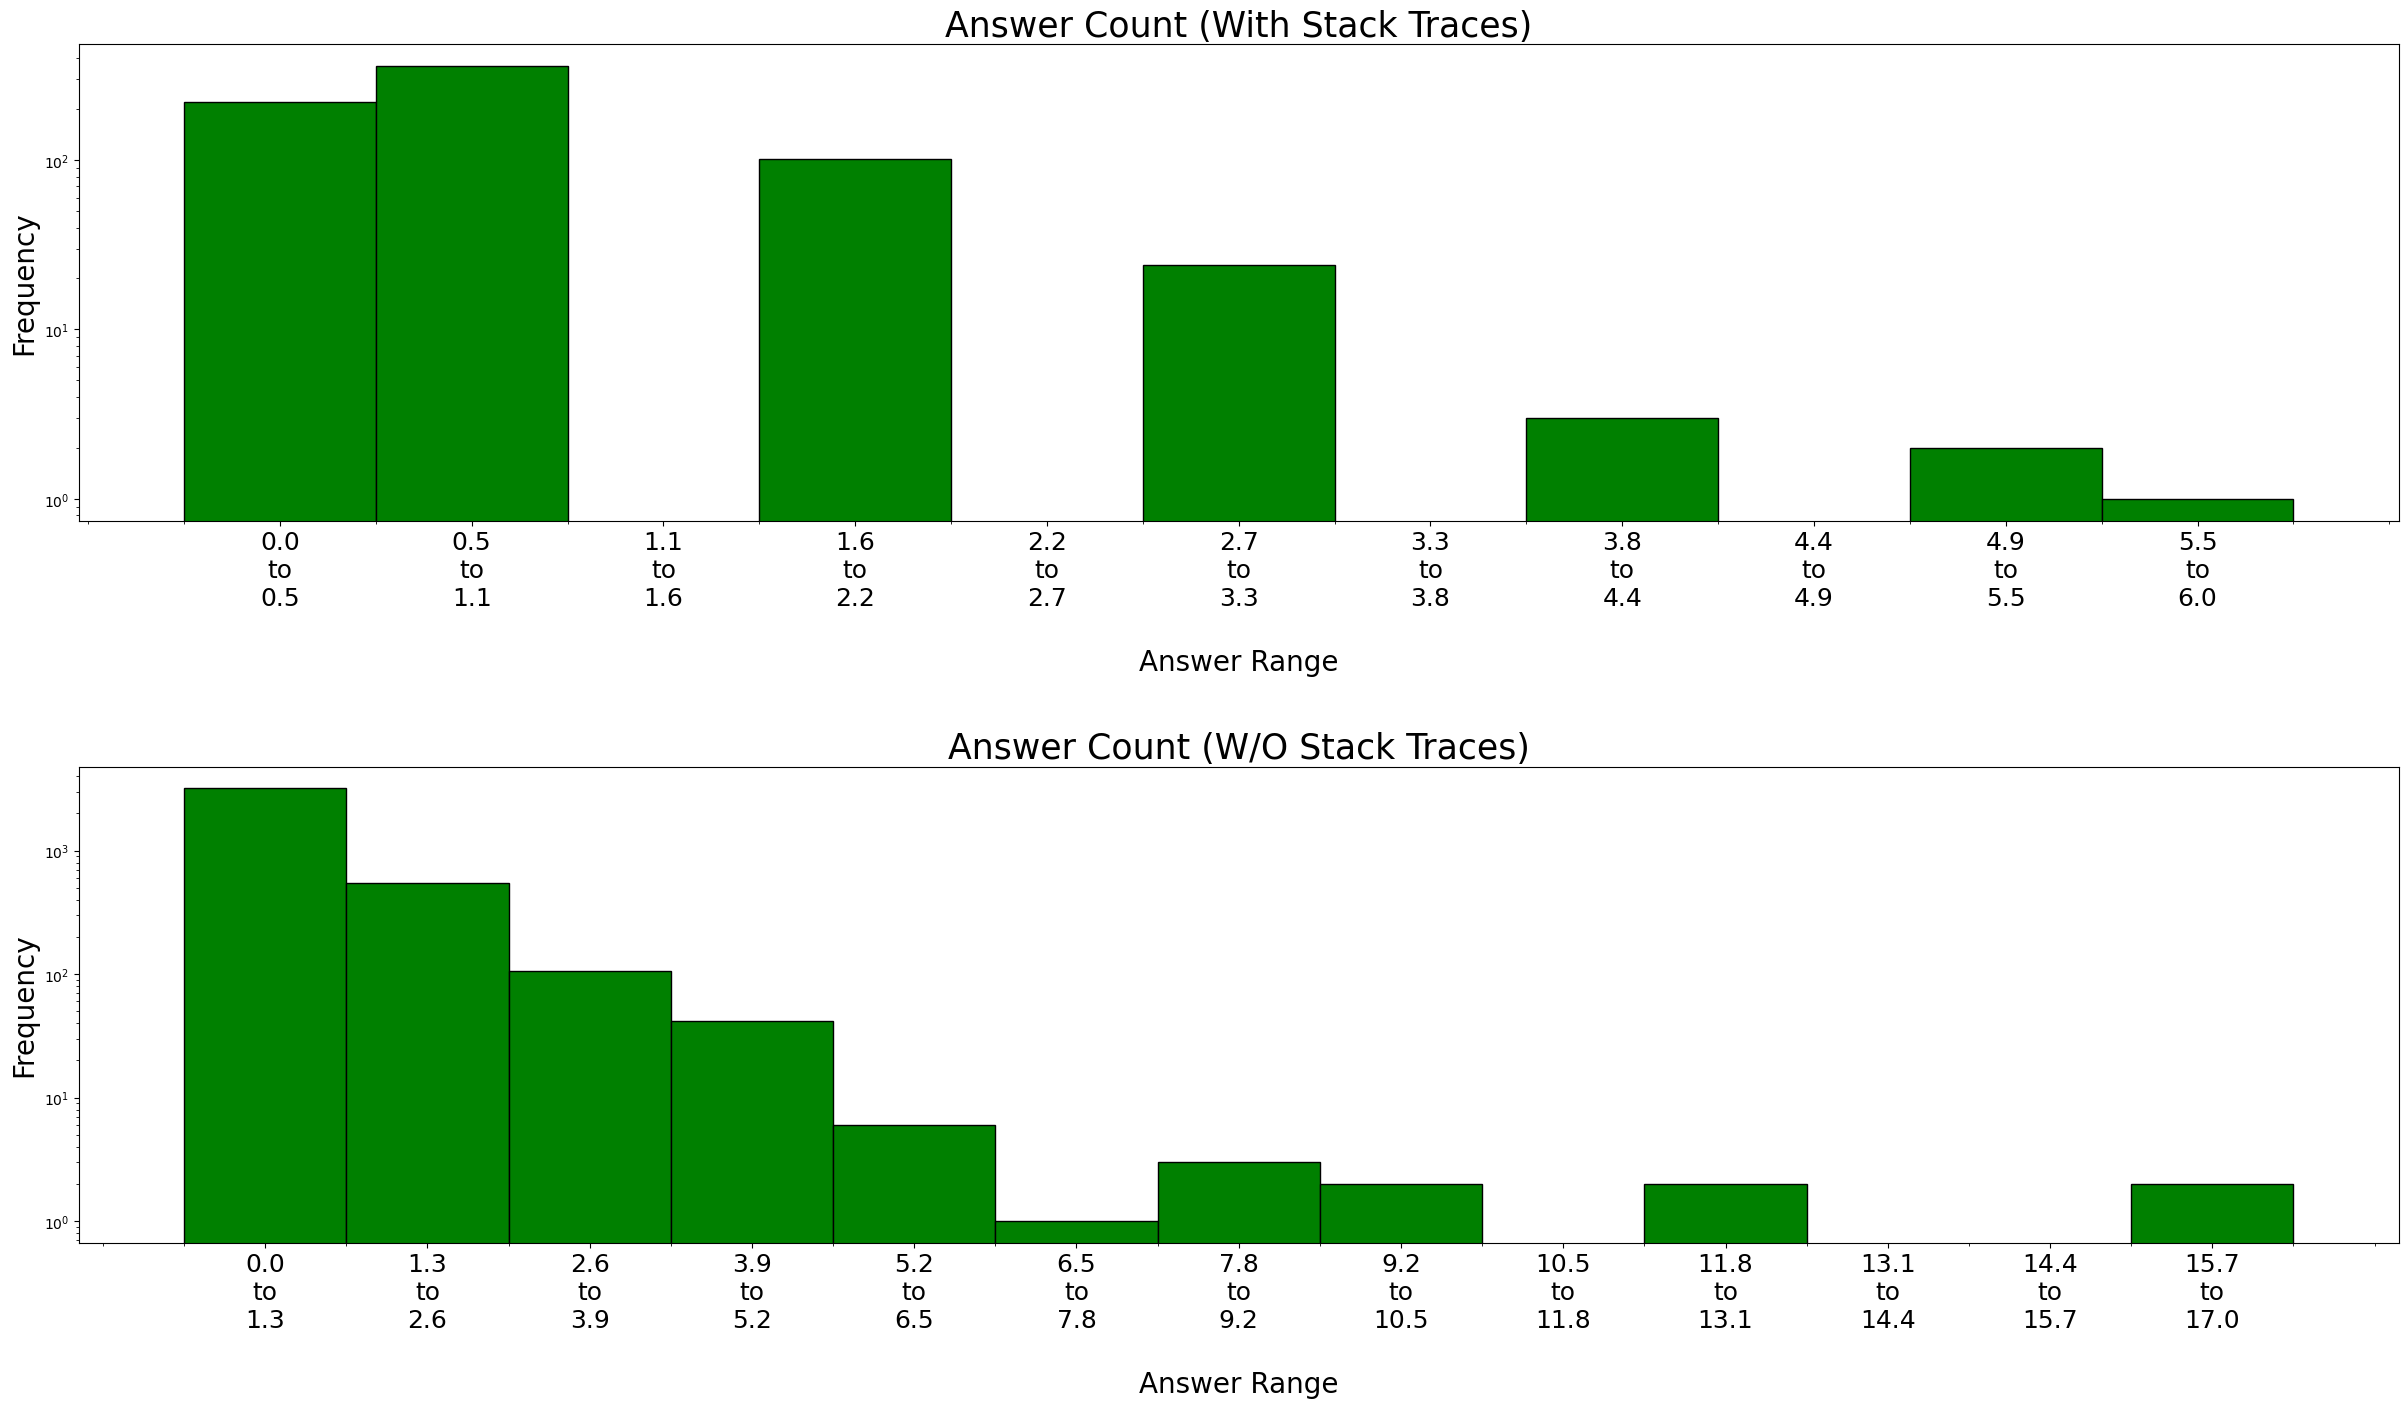

In [241]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Answer Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nAnswer Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Answer_count']))

n, bins, patches = plt.hist(df_status_w_stack['Answer_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='g', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Answer Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nAnswer Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Answer_count']))

n, bins, patches = plt.hist(df_status_wo_stack['Answer_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='g', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)
plt.show()

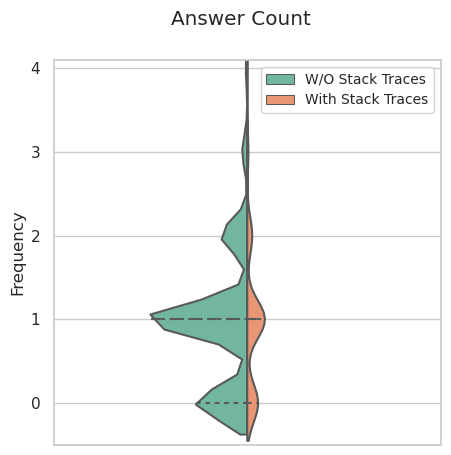

In [242]:
sns.set_theme(style="whitegrid")
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Answer_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Answer_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-.5,4.1)
# plt.xlim(-1,1)

fig.suptitle('Answer Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})

plt.show()

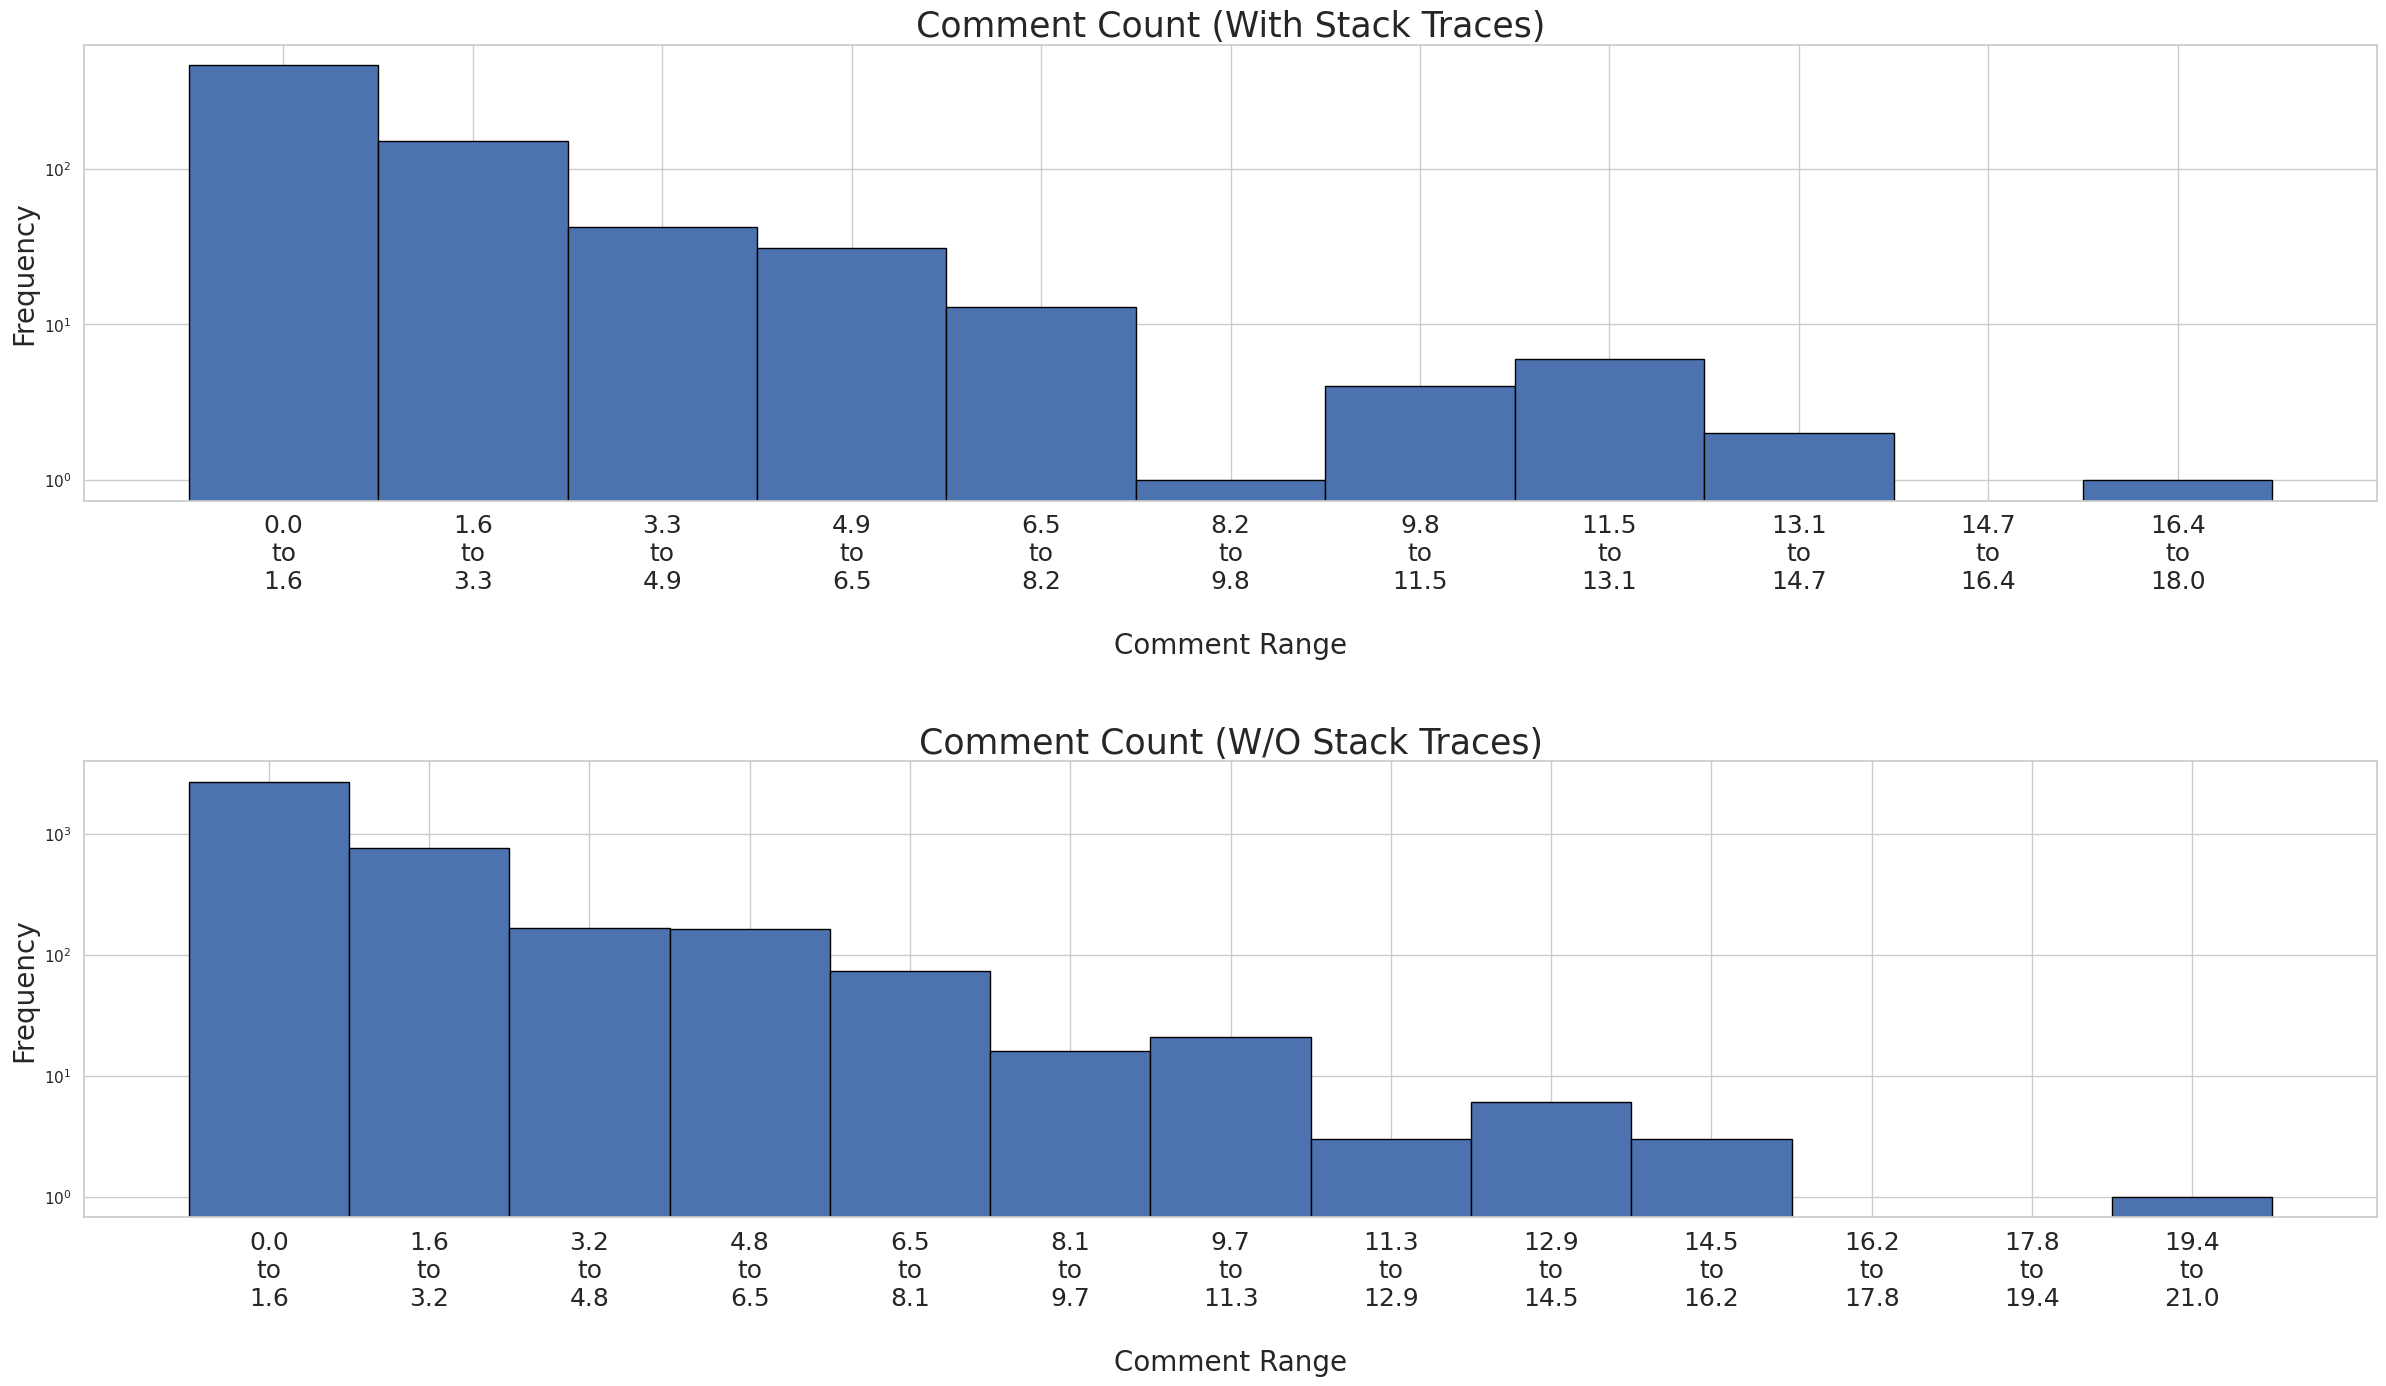

In [243]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Comment Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nComment Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Comment_count']))

n, bins, patches = plt.hist(df_status_w_stack['Comment_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='b', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Comment Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nComment Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Comment_count']))

n, bins, patches = plt.hist(df_status_wo_stack['Comment_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='b', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)

plt.show()

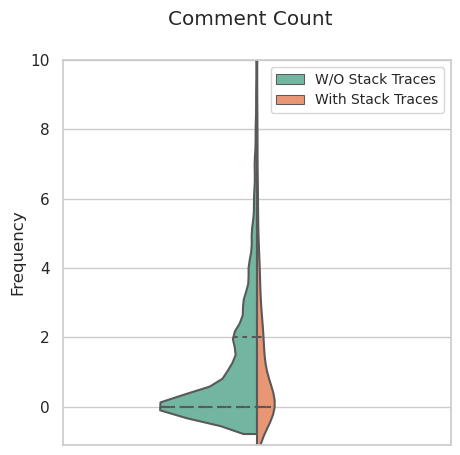

In [244]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Comment_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Comment_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-1.1,10)
# plt.xlim(-1,1)

fig.suptitle('Comment Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})

plt.show()

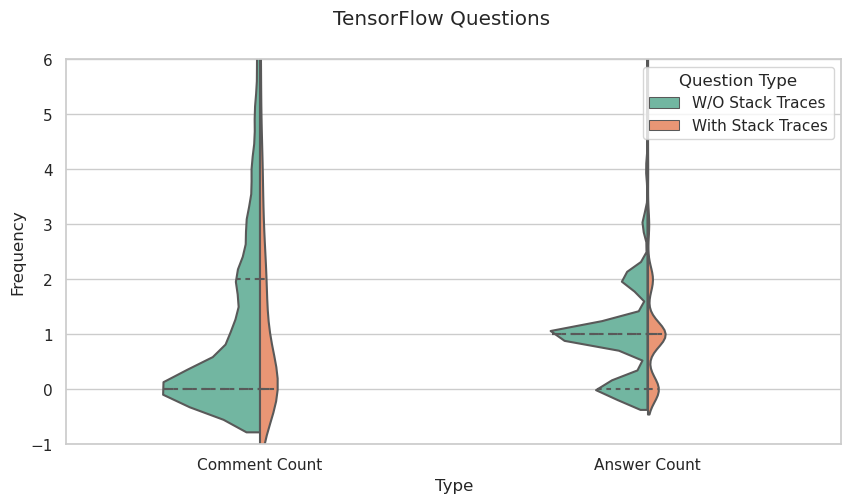

In [245]:
# Example:

sns.set_theme(style="whitegrid")
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Comment_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Comment_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

resultComment = pd.concat([df_1, df_2])
resultComment['Type'] = "Comment Count"
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Answer_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Answer_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

resultAnswer = pd.concat([df_1, df_2])
resultAnswer['Type'] = "Answer Count"
# ###################################################################################
# df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_1['Frequency'] = df_status_wo_stack['View_count']
# df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

# df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_2['Frequency'] = df_status_w_stack['View_count']
# df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

# resultView = pd.concat([df_1, df_2])
# resultView['Type'] = "View Count"
# ###################################################################################
# df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_1['Frequency'] = df_status_wo_stack['Score']
# df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

# df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_2['Frequency'] = df_status_w_stack['Score']
# df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

# resultScore = pd.concat([df_1, df_2])
# resultScore['Type'] = "Score Count"
# ###################################################################################
result = pd.concat([resultComment, resultAnswer], ignore_index=True)

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-1,6)
# plt.xlim(-1,1)

fig.suptitle('TensorFlow Questions')
# fig.suptitle('TensorFlow Questions', prop={"size":10})
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.legend(loc='upper left')

plt.show()

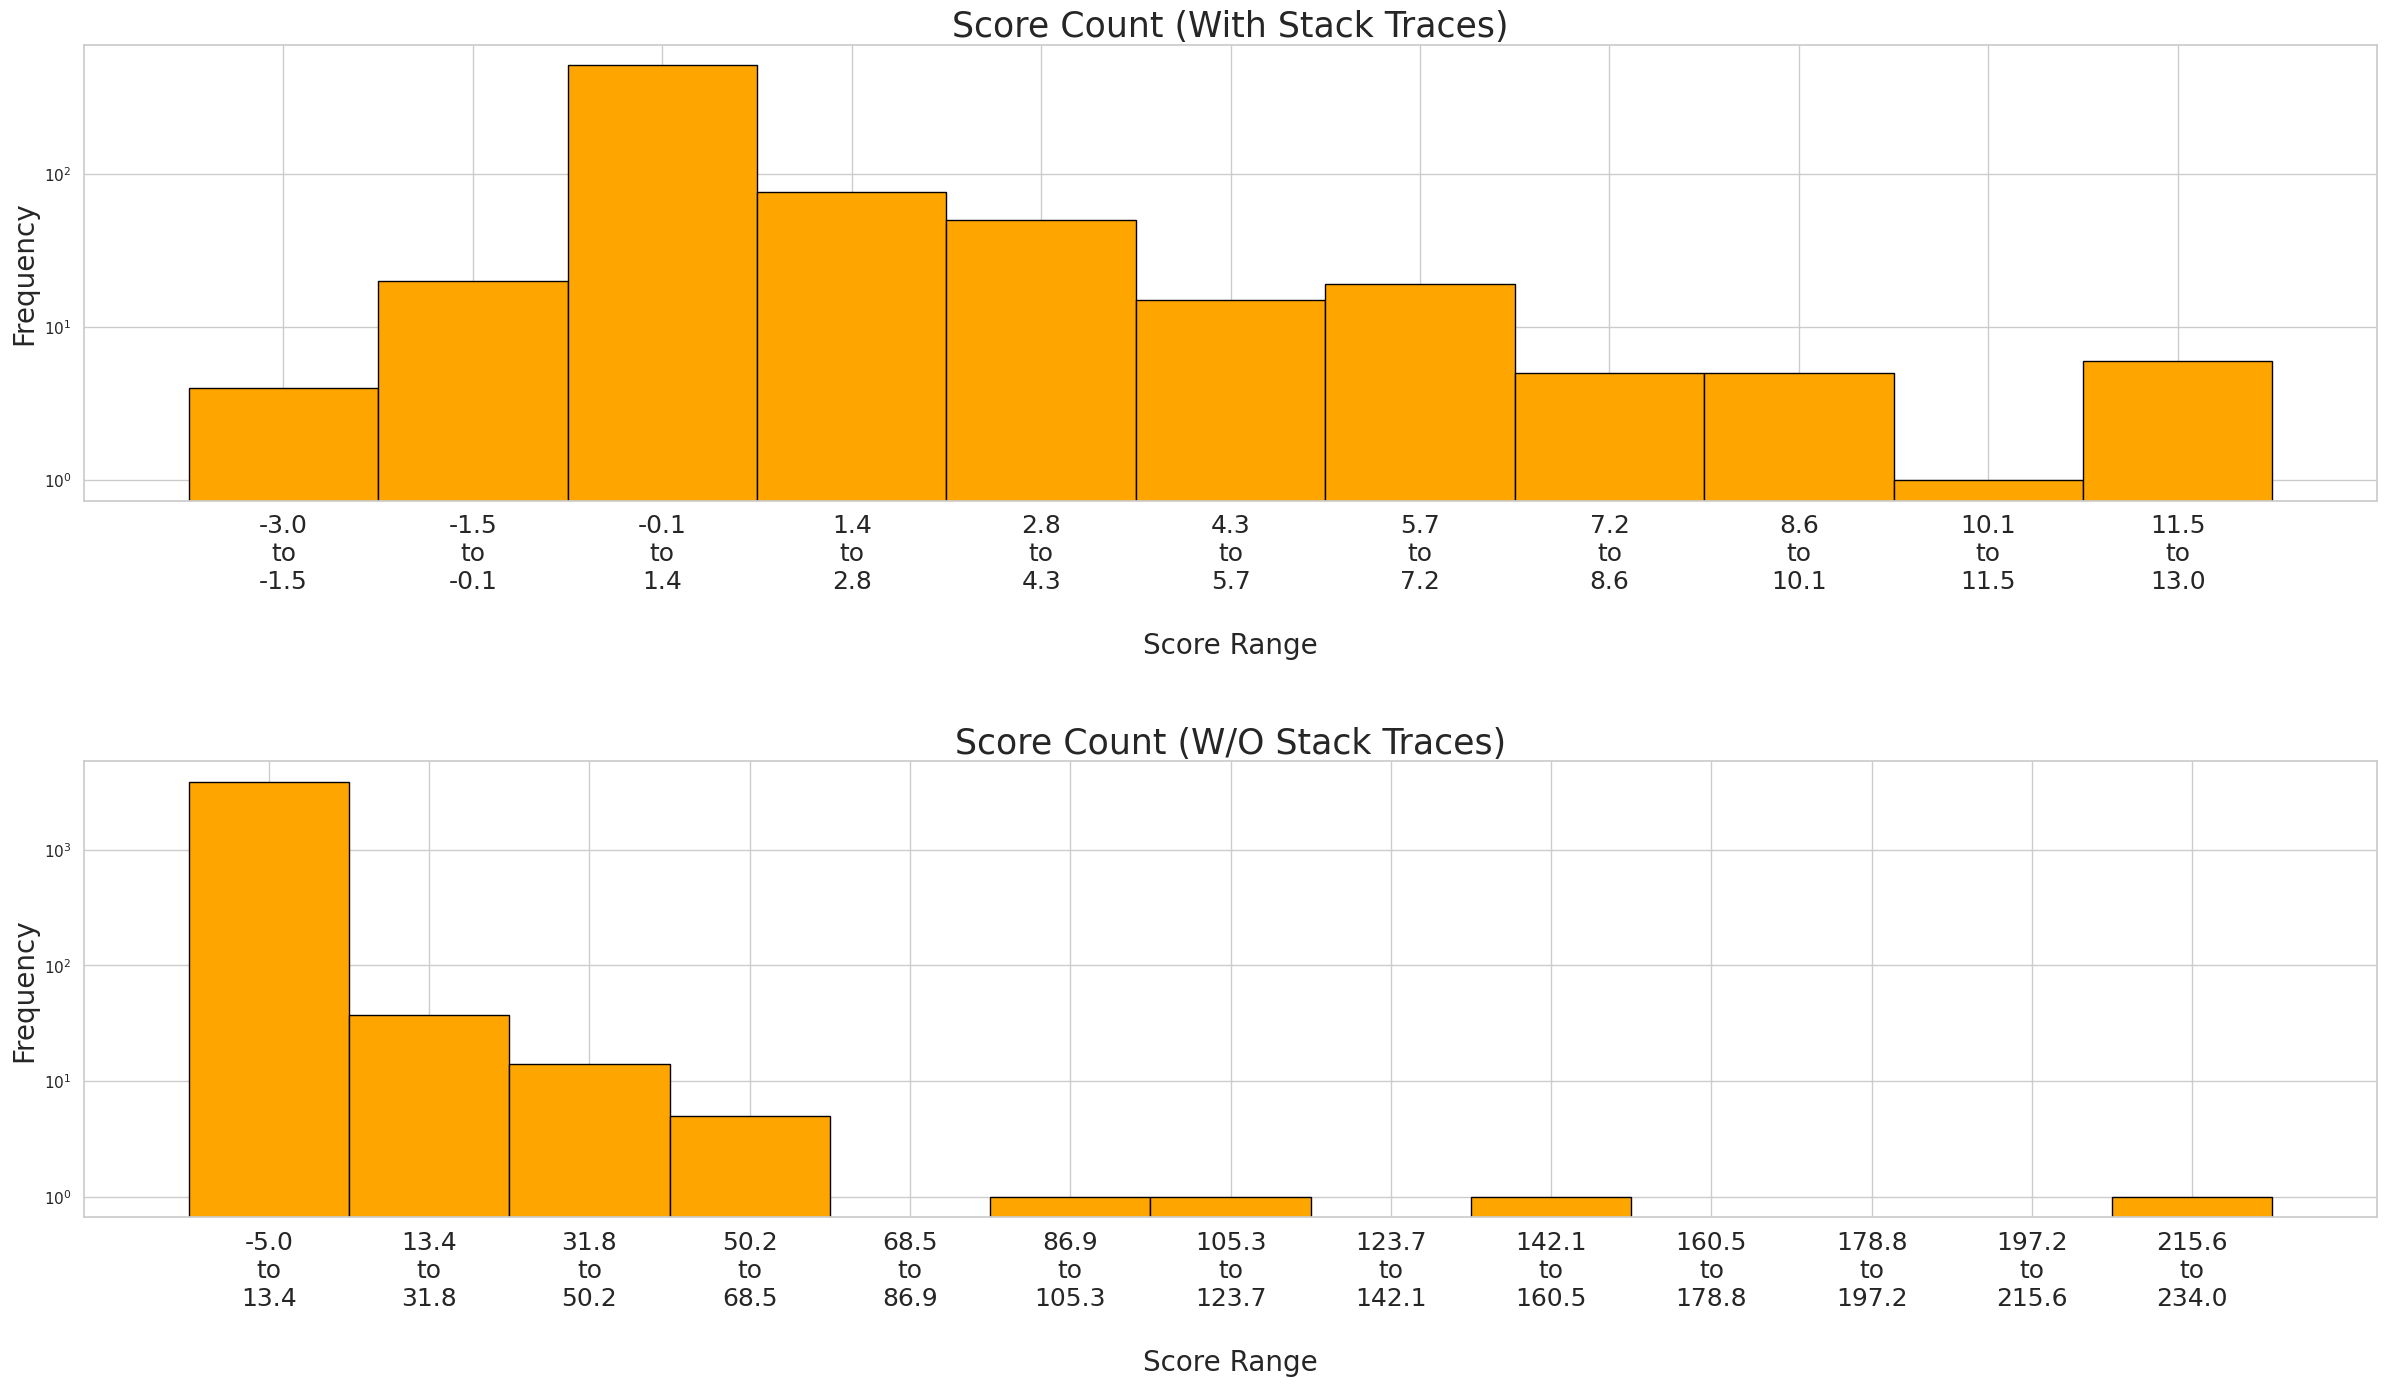

In [246]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Score Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nScore Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Score']))

n, bins, patches = plt.hist(df_status_w_stack['Score'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='orange', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Score Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nScore Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Score']))

n, bins, patches = plt.hist(df_status_wo_stack['Score'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='orange', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)
plt.show()

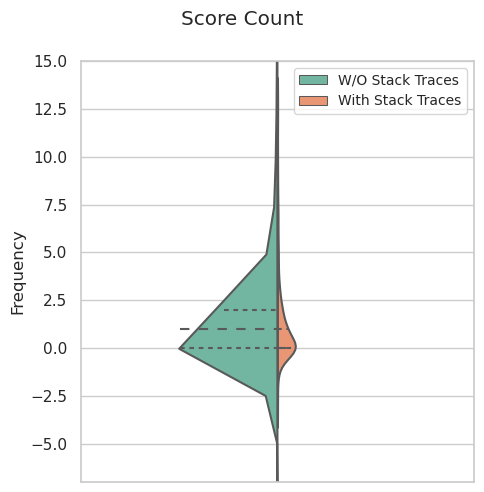

In [247]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Score']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Score']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-7,15)
# plt.xlim(-1,1)

fig.suptitle('Score Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})
fig.tight_layout()
plt.show()



In [248]:
# facecolor = '#EAEAEA'
# color_bars = '#3475D0'
# txt_color1 = '#252525'
# txt_color2 = '#004C74'
# fig, ax = plt.subplots(1, figsize=(20,6), facecolor=facecolor)
# ax.set_facecolor(facecolor)
# n, bins, patches = plt.hist(df_status_w_stack['Score'], 
#                              bins=n_bins, color=color_bars, log=True)
# #grid
# minor_locator = AutoMinorLocator(2)
# plt.gca().xaxis.set_minor_locator(minor_locator)
# # plt.grid(which='minor', color=facecolor, lw = 0.5)
# xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
# xticks_labels = [ "{:.0f}-{:.0f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
# plt.xticks(xticks, labels=xticks_labels, c=txt_color1, fontsize=13)

# # remove major and minor ticks from the x axis, but keep the labels
# ax.tick_params(axis='x', which='both',length=0)
# # remove y ticks
# plt.yticks([])

# # Hide the right and top spines
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for idx, value in enumerate(n):
#     if value > 0:
#         plt.text(xticks[idx], value+5, int(value), ha='center', fontsize=16, c=txt_color1)

# plt.title('\nTensorFlow - Score Count\n', loc = 'center', fontsize = 20, c=txt_color1)
# plt.xlabel('\nScore Range', c=txt_color2, fontsize=14)
# plt.ylabel('\nFrequency', c=txt_color2, fontsize=14)
# plt.tight_layout()
# # plt.savefig('costs.png', facecolor=facecolor)

In [249]:
# import datetime

# flag = 0
# fr_time = pd.to_datetime(datetime.datetime.now())
# acc_time = pd.to_datetime(datetime.datetime.now())

# for answer in tt:
#     anwer_time = pd.to_datetime(answer[1])
#     if flag == 0:
#         fr_time = anwer_time
#         flag = 1
    
#     if fr_time > anwer_time:
#         fr_time = anwer_time
    
#     if int(60535969) == answer[0]:
#         acc_time = anwer_time

# print(fr_time)
# print(acc_time)

In [ ]:
# fig = plt.figure(figsize=(10, 5))
# gs = fig.add_gridspec(1, 2)

# min_ = min(min(df_status_w_stack['View_count']), min(df_status_wo_stack['View_count']))
# max_ = max(max(df_status_w_stack['View_count']), max(df_status_wo_stack['View_count']))

# ax1 = fig.add_subplot(gs[0, 0])
# sns.violinplot(data=df_status_w_stack['View_count'])
# ax1.set_xlabel("with Stack Traces")
# ax1.set_ylabel("Frequency")
# ax1 = plt.ylim(min_,max_)

# ax2 = fig.add_subplot(gs[0, 1])
# sns.violinplot(data=df_status_wo_stack['View_count'])
# ax2.set_xlabel("w/o Stack Traces")
# ax2.set_ylabel("Frequency")
# ax2 = plt.ylim(min_,max_)